# Data Import and Processing

In [ ]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from scipy import stats
from scipy.stats import boxcox

filterwarnings('ignore')

In [ ]:
df = pd.read_csv("Air_Traffic_Passenger_Statistics_20241115.csv", delimiter=",")

In [ ]:
df.head()

Activity Period Activity Period Start Date  \
0           199907                 1999/07/01   
1           199907                 1999/07/01   
2           199907                 1999/07/01   
3           199907                 1999/07/01   
4           199907                 1999/07/01   

                         Operating Airline Operating Airline IATA Code  \
0                             ATA Airlines                          TZ   
1                             ATA Airlines                          TZ   
2                             ATA Airlines                          TZ   
3  Aeroflot Russian International Airlines                         NaN   
4  Aeroflot Russian International Airlines                         NaN   

                         Published Airline Published Airline IATA Code  \
0                             ATA Airlines                          TZ   
1                             ATA Airlines                          TZ   
2                             ATA Airlines                          TZ   
3  Aeroflot Russian International Airlines                         NaN   
4  Aeroflot Russian International Airlines                         NaN   

     GEO Summary GEO Region Activity Type Code Price Category Code  \
0       Domestic         US           Deplaned            Low Fare   
1       Domestic         US           Enplaned            Low Fare   
2       Domestic         US     Thru / Transit            Low Fare   
3  International     Europe           Deplaned               Other   
4  International     Europe           Enplaned               Other   

     Terminal Boarding Area  Passenger Count              data_as_of  \
0  Terminal 1             B            31432  2024/10/20 01:00:51 PM   
1  Terminal 1             B            31353  2024/10/20 01:00:51 PM   
2  Terminal 1             B             2518  2024/10/20 01:00:51 PM   
3  Terminal 2             D             1324  2024/10/20 01:00:51 PM   
4  Terminal 2             D             1198  2024/10/20 01:00:51 PM   

           data_loaded_at  
0  2024/10/22 03:01:56 PM  
1  2024/10/22 03:01:56 PM  
2  2024/10/22 03:01:56 PM  
3  2024/10/22 03:01:56 PM  
4  2024/10/22 03:01:56 PM

In [ ]:
df = df[["Activity Period Start Date","Activity Type Code","Passenger Count"]]

In [ ]:
df.head()

Activity Period Start Date Activity Type Code  Passenger Count
0                 1999/07/01           Deplaned            31432
1                 1999/07/01           Enplaned            31353
2                 1999/07/01     Thru / Transit             2518
3                 1999/07/01           Deplaned             1324
4                 1999/07/01           Enplaned             1198

In [ ]:
df['Activity Period Start Date'] = pd.to_datetime(df['Activity Period Start Date'], format='%Y/%m/%d')

# Calculate the total passenger count for each day
df = (
    df.groupby('Activity Period Start Date')
    .apply(lambda x: x.loc[x['Activity Type Code'].isin(['Enplaned', 'Deplaned']), 'Passenger Count'].sum() +
                   x.loc[x['Activity Type Code'] == 'Thru / Transit', 'Passenger Count'].sum() * 2)
    .reset_index(name='Total Passenger Count')
)

In [ ]:
df.head()

Activity Period Start Date  Total Passenger Count
0                 1999-07-01                4009948
1                 1999-08-01                4005100
2                 1999-09-01                3365417
3                 1999-10-01                3499825
4                 1999-11-01                3173576

# Exploratory Data Analysis

## Time Series Plots

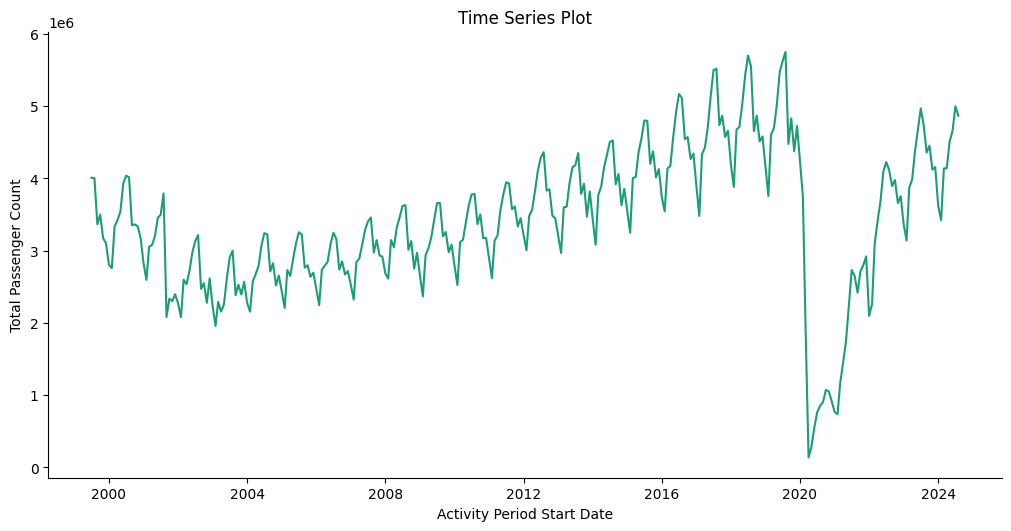

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Activity Period Start Date']
  ys = series['Total Passenger Count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Activity Period Start Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Activity Period Start Date')
_ = plt.ylabel('Total Passenger Count')
plt.title('Time Series Plot')
plt.show()

In [ ]:
# Truncate the series until the 2019-2020 (Covid-19)
df_trunc1 = df[df['Activity Period Start Date'] < pd.to_datetime('2020-01-01')]
df_trunc2 = df[df['Activity Period Start Date'] >= pd.to_datetime('2020-01-01')]

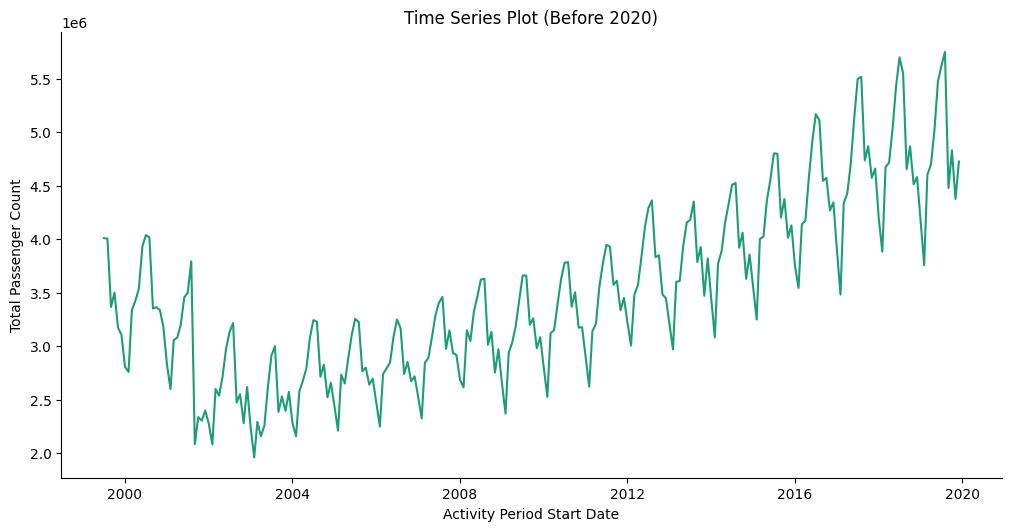

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Activity Period Start Date']
  ys = series['Total Passenger Count']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_trunc1.sort_values('Activity Period Start Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Activity Period Start Date')
_ = plt.ylabel('Total Passenger Count')
plt.title('Time Series Plot (Before 2020)')
plt.show()

## Seasonal Plot

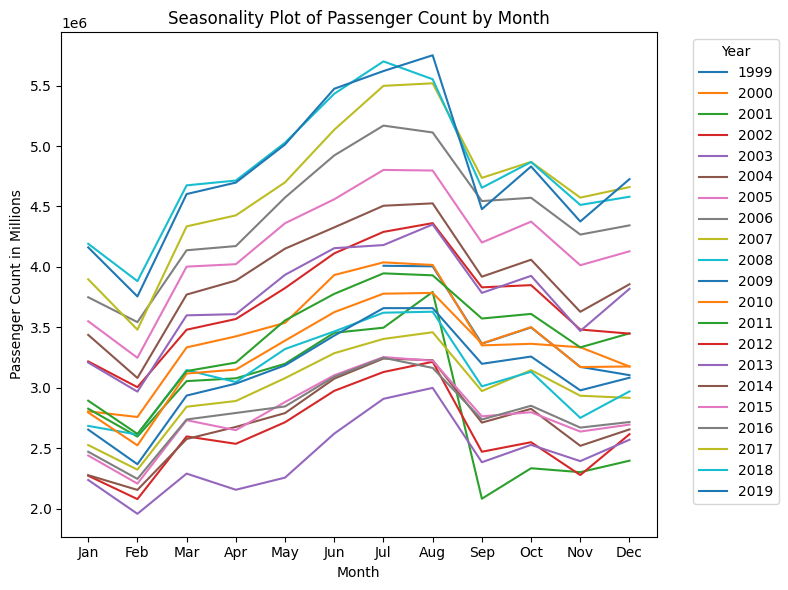

In [ ]:
# Set date column as index
df_trunc1['month'] = df_trunc1['Activity Period Start Date'].dt.month  # Extract month for grouping
df_trunc1['year'] = df_trunc1['Activity Period Start Date'].dt.year    # Extract year for labeling

plt.figure(figsize=(8, 6))

# Group by month and plot
for year, group in df_trunc1.groupby('year'):
    plt.plot(group['month'], group['Total Passenger Count'], label=year)

# Add labels, title, and legend
plt.title('Seasonality Plot of Passenger Count by Month')
plt.xlabel('Month')
plt.ylabel('Passenger Count in Millions')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Lag Plots

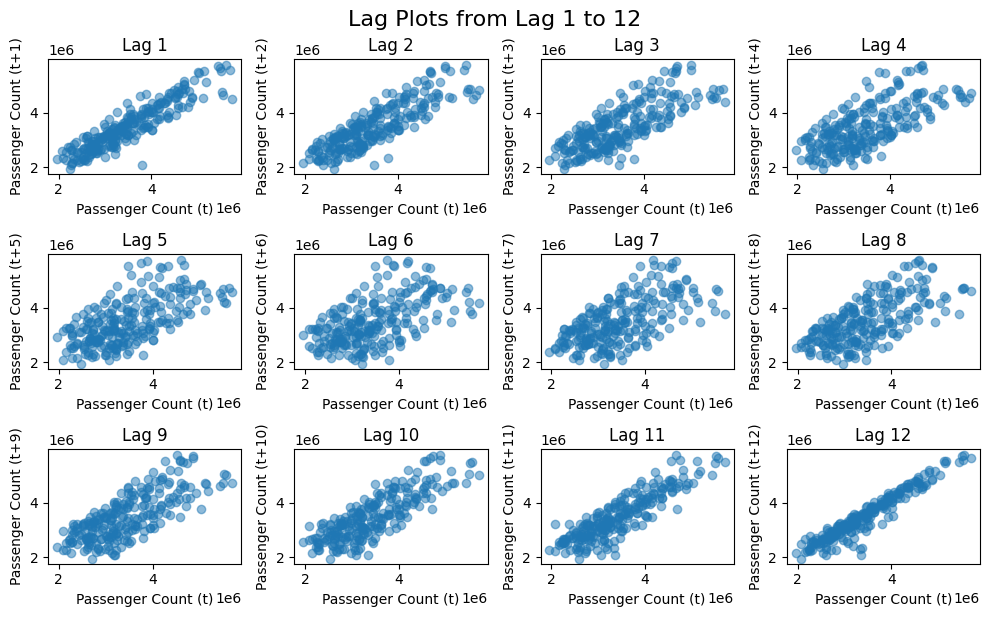

In [ ]:
# Ensure 'Activity Period Start Date' is a datetime column
df_trunc1['Activity Period Start Date'] = pd.to_datetime(df_trunc1['Activity Period Start Date'])

# Sort the DataFrame by date to ensure proper ordering
df_trunc1 = df_trunc1.sort_values('Activity Period Start Date')

# Extract the passenger count column
series = df_trunc1['Total Passenger Count']

# Create lag plots from lag 1 to lag 12
plt.figure(figsize=(10, 6))  # Adjust figure size for better layout
for lag in range(1, 13):  # From lag 1 to lag 12
    plt.subplot(3, 4, lag)  # Create a grid of 3 rows and 4 columns
    plt.scatter(series[:-lag], series[lag:], alpha=0.5)
    plt.title(f'Lag {lag}')
    plt.xlabel('Passenger Count (t)')
    plt.ylabel(f'Passenger Count (t+{lag})')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.suptitle('Lag Plots from Lag 1 to 12', y=1.02, fontsize=16)  # Add a main title
plt.show()

# ACF, PACF and Transformation

In [ ]:
# Split data into training and test data
# Ensure the dataset is sorted by time
df_trunc1 = df_trunc1.sort_index()

# Determine the split index for the last year (as forecast)
test_size = 12
split_index = -test_size

# Split the dataset
df_train = df_trunc1.iloc[:split_index]
df_test = df_trunc1.iloc[split_index:]

# Output the results
print("Training Data:")
print(df_train)
print("\nTest Data:")
print(df_test)

Training Data:
    Activity Period Start Date  Total Passenger Count  month  year
0                   1999-07-01                4009948      7  1999
1                   1999-08-01                4005100      8  1999
2                   1999-09-01                3365417      9  1999
3                   1999-10-01                3499825     10  1999
4                   1999-11-01                3173576     11  1999
..                         ...                    ...    ...   ...
229                 2018-08-01                5552579      8  2018
230                 2018-09-01                4655093      9  2018
231                 2018-10-01                4867897     10  2018
232                 2018-11-01                4513070     11  2018
233                 2018-12-01                4580901     12  2018

[234 rows x 4 columns]

Test Data:
    Activity Period Start Date  Total Passenger Count  month  year
234                 2019-01-01                4161927      1  2019
235        

In [ ]:
print(df_train.columns)
print(df_test.columns)

Index(['Activity Period Start Date', 'Total Passenger Count', 'month', 'year'], dtype='object')
Index(['Activity Period Start Date', 'Total Passenger Count', 'month', 'year'], dtype='object')


## ACF and PACF

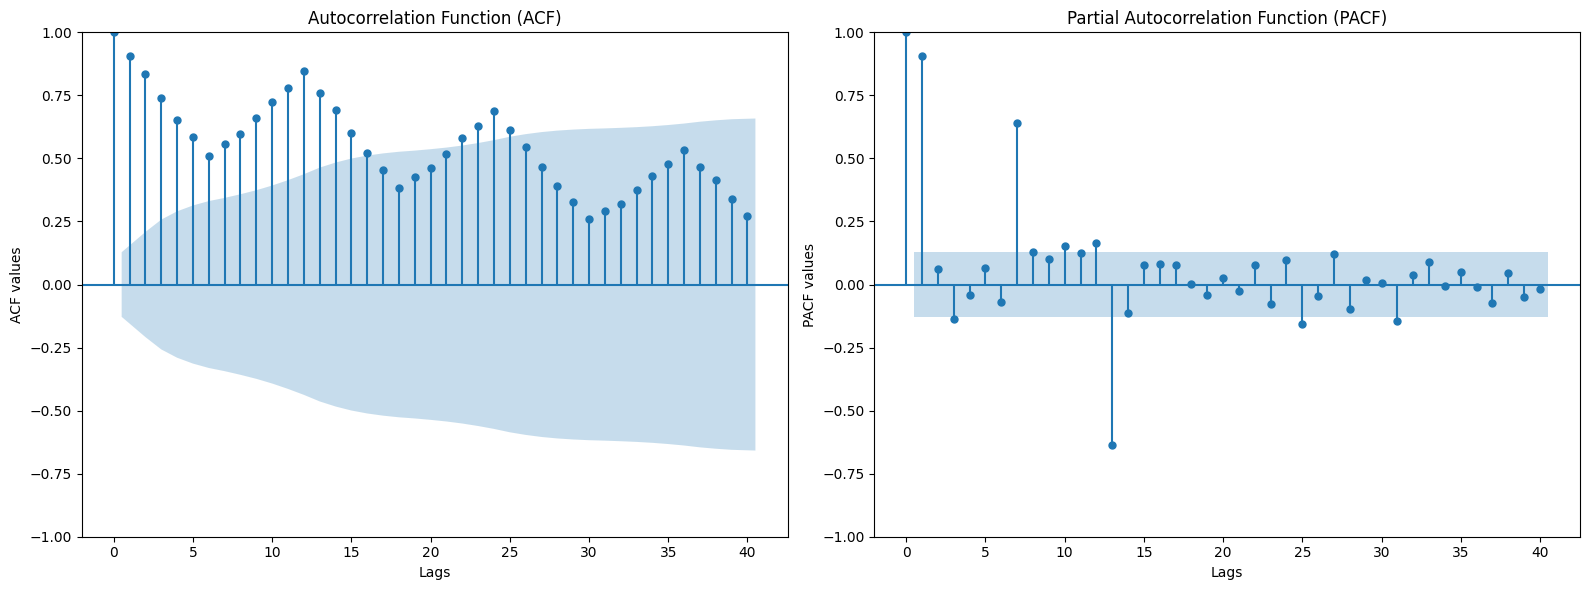

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Extract the 'Total Passenger Count' column
total_passenger_count = df_train['Total Passenger Count']

# Plot ACF and PACF with significance bands
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot with significance bands
plot_acf(total_passenger_count, ax=axes[0], lags=40, alpha=0.05, bartlett_confint = True)  # Significance bands included by default
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lags')
axes[0].set_ylabel('ACF values')

# PACF plot with significance bands
plot_pacf(total_passenger_count, ax=axes[1], lags=40, method='ywm', alpha=0.05)  # Same for PACF
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('PACF values')

plt.tight_layout()
plt.show()

# horizontal R line could be plotted with y=[+/-]1.96 / np.sqrt(len(data)), Python uses the more sophisticated Barlett formula for the significance bands

## Box Cox Transformation

In [ ]:
# Extract the 'Total Passenger Count' column
total_passenger_count = df_train['Total Passenger Count']

# Apply the Box-Cox transformation
total_passenger_count_boxcox, lambda_value = boxcox(total_passenger_count)

# Add transformed data back to the dataframe
df_train['Total Passenger Count (Box-Cox)'] = total_passenger_count_boxcox

# Display lambda value and the first few rows of the transformed data
print(f"Lambda (Box-Cox Transformation): {lambda_value}")
print(df_train[['Total Passenger Count', 'Total Passenger Count (Box-Cox)']].head())

Lambda (Box-Cox Transformation): -0.1594682581690191
   Total Passenger Count  Total Passenger Count (Box-Cox)
0                4009948                         5.715787
1                4005100                         5.715680
2                3365417                         5.700058
3                3499825                         5.703612
4                3173576                         5.694691


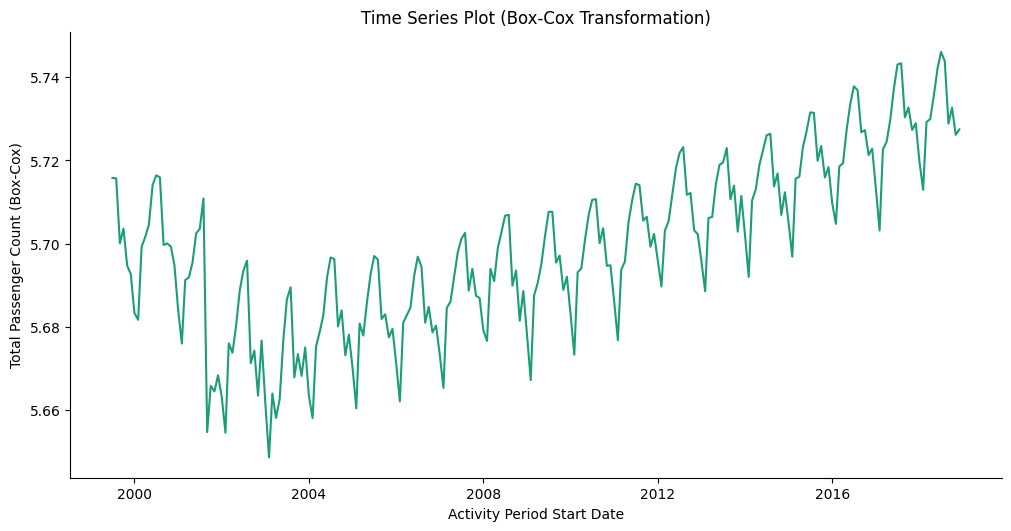

In [ ]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Activity Period Start Date']
  ys = series['Total Passenger Count (Box-Cox)']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])
  plt.title('Time Series Plot (Box-Cox Transformation)')

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_train.sort_values('Activity Period Start Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)

plt.title('Time Series Plot (Box-Cox Transformation)')
plt.xlabel('Activity Period Start Date')
_ = plt.ylabel('Total Passenger Count (Box-Cox)')

## Differencing

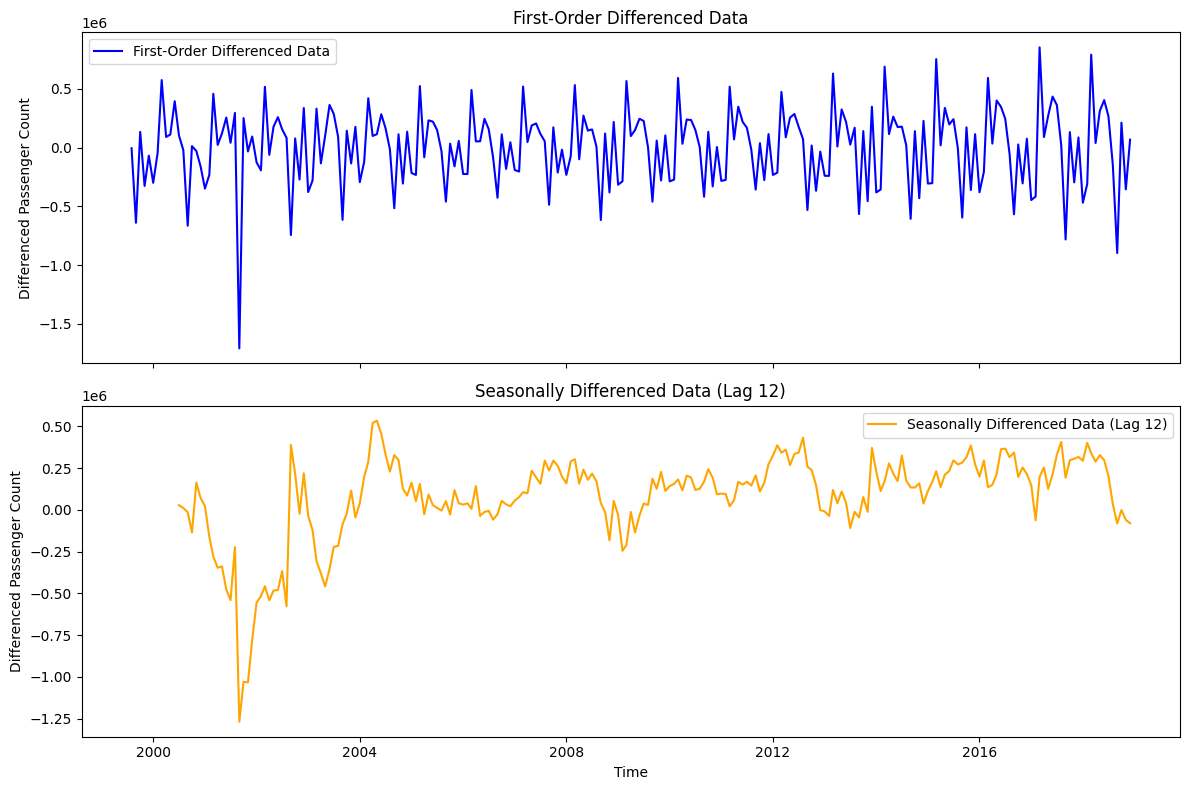

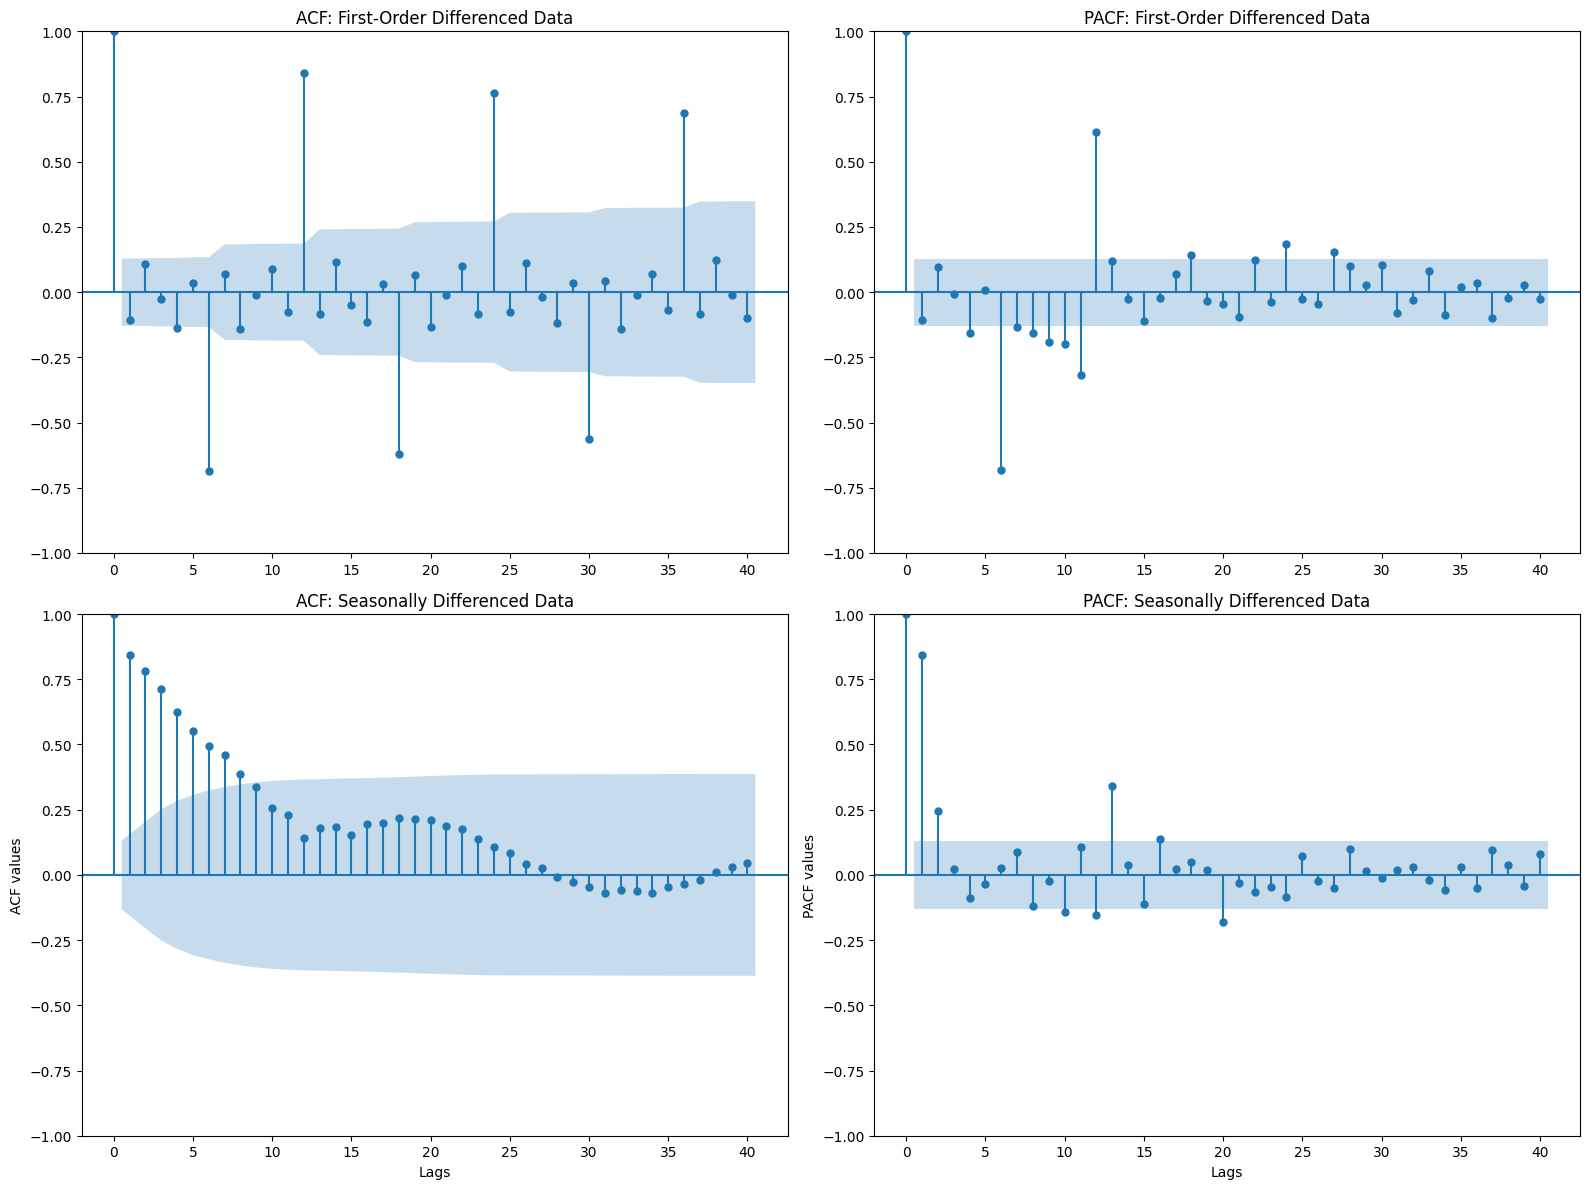

In [ ]:
# First-order differencing
df_train['Differenced'] = df_train['Total Passenger Count'].diff()

# Seasonal differencing (assuming monthly data with 12-month seasonality)
df_train['Seasonally Differenced'] = df_train['Total Passenger Count'].diff(12)

# Drop NaN values caused by differencing
differenced_data = df_train[['Activity Period Start Date', 'Differenced']].dropna()
seasonally_differenced_data = df_train[['Activity Period Start Date', 'Seasonally Differenced']].dropna()

# Convert 'Activity Period Start Date' to datetime if not already
df_train['Activity Period Start Date'] = pd.to_datetime(df_train['Activity Period Start Date'])


# Plot differenced and seasonally differenced data
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# First-Order Differenced Data
ax[0].plot(differenced_data['Activity Period Start Date'], differenced_data['Differenced'], label="First-Order Differenced Data", color="blue")
ax[0].set_title("First-Order Differenced Data")
ax[0].set_ylabel("Differenced Passenger Count")
ax[0].legend()

# Seasonally Differenced Data
ax[1].plot(seasonally_differenced_data['Activity Period Start Date'], seasonally_differenced_data['Seasonally Differenced'], label="Seasonally Differenced Data (Lag 12)", color="orange")
ax[1].set_title("Seasonally Differenced Data (Lag 12)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Differenced Passenger Count")
ax[1].legend()

plt.tight_layout()
plt.show()

df_train['Differenced'].to_csv('differenced_data.csv', index=False)
df_train['Seasonally Differenced'].to_csv('seasonally_differenced_data.csv', index=False)

# Plot ACF and PACF for both differenced datasets
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi = 100)

# ACF and PACF for first-order differenced data
plot_acf(differenced_data['Differenced'], ax=axes[0, 0], lags=40)
axes[0, 0].set_title("ACF: First-Order Differenced Data")
plot_pacf(differenced_data['Differenced'], ax=axes[0, 1], lags=40, method='ywm')
axes[0, 1].set_title("PACF: First-Order Differenced Data")

# ACF and PACF for seasonally differenced data
plot_acf(seasonally_differenced_data['Seasonally Differenced'], ax=axes[1, 0], lags=40)
axes[1, 0].set_title("ACF: Seasonally Differenced Data")
axes[1, 0].set_xlabel("Lags")
axes[1, 0].set_ylabel("ACF values")
plot_pacf(seasonally_differenced_data['Seasonally Differenced'], ax=axes[1, 1], lags=40, method='ywm')
axes[1, 1].set_title("PACF: Seasonally Differenced Data")
axes[1, 1].set_xlabel("Lags")
axes[1, 1].set_ylabel("PACF values")

plt.tight_layout()
plt.show()

In [ ]:
 !pip install pmdarima

In [ ]:
from pmdarima.arima import ndiffs, nsdiffs
import pandas as pd

# Ensure the time series is properly formatted as a pandas Series
y = df_train["Total Passenger Count (Box-Cox)"].dropna()

# Calculate the optimal number of seasonal differencing (nsdiffs)
D = nsdiffs(y, m=12)  # Set m to the seasonal period (e.g., 12 for monthly data)
print(f"Optimal number of seasonal differencing (D): {D}")

# Apply seasonal differencing D times BEFORE doing the regular differencing
for i in range(D):
    y = y.diff(periods=12)

# Calculate the optimal number of regular differencing (ndiffs)
d = ndiffs(y, test='adf')  # 'adf', 'kpss', or 'pp' for different stationarity tests
print(f"Optimal number of regular differencing (d): {d}")
# no seasonal differencing and for normal differencing only kpss gives 1, adf and pp give 0

Optimal number of seasonal differencing (D): 0
Optimal number of regular differencing (d): 1


# Modeling

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import numpy as np

def plot_diagnostics(model_results, model_name, max_lag=35):
    residuals = model_results.resid
    standardized_residuals = (residuals - residuals.mean()) / residuals.std()

    # Create a new figure for diagnostics
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Time series plot of standardized residuals
    axes[0, 0].plot(standardized_residuals, marker='o', linestyle='-', alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', label='Zero Line')
    axes[0, 0].set_title(f"Standardized Residuals Time Series ({model_name})")
    axes[0, 0].set_xlabel("Time")
    axes[0, 0].set_ylabel("Standardized Residuals")
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    # Plot ACF of residuals
    plot_acf(standardized_residuals, lags=20, alpha=0.05, ax=axes[0, 1])
    axes[0, 1].set_title(f"ACF of Residuals ({model_name})")

    # Q-Q plot
    qqplot(standardized_residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set_title(f"Normal Q-Q Plot ({model_name})")

    # Ljung-Box test p-values for multiple lags
    lb_test = acorr_ljungbox(standardized_residuals, lags=np.arange(1, max_lag + 1), return_df=True)
    p_values = lb_test['lb_pvalue']

    # Ljung-Box p-values stem plot
    axes[1, 1].stem(p_values.index, p_values, basefmt=" ")
    axes[1, 1].axhline(y=0.05, color='blue', linestyle='--', label='Significance Level (0.05)')
    axes[1, 1].set_title(f'Ljung-Box Test p-values ({model_name})')
    axes[1, 1].set_xlabel('Lag (H)')
    axes[1, 1].set_ylabel('p-value')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

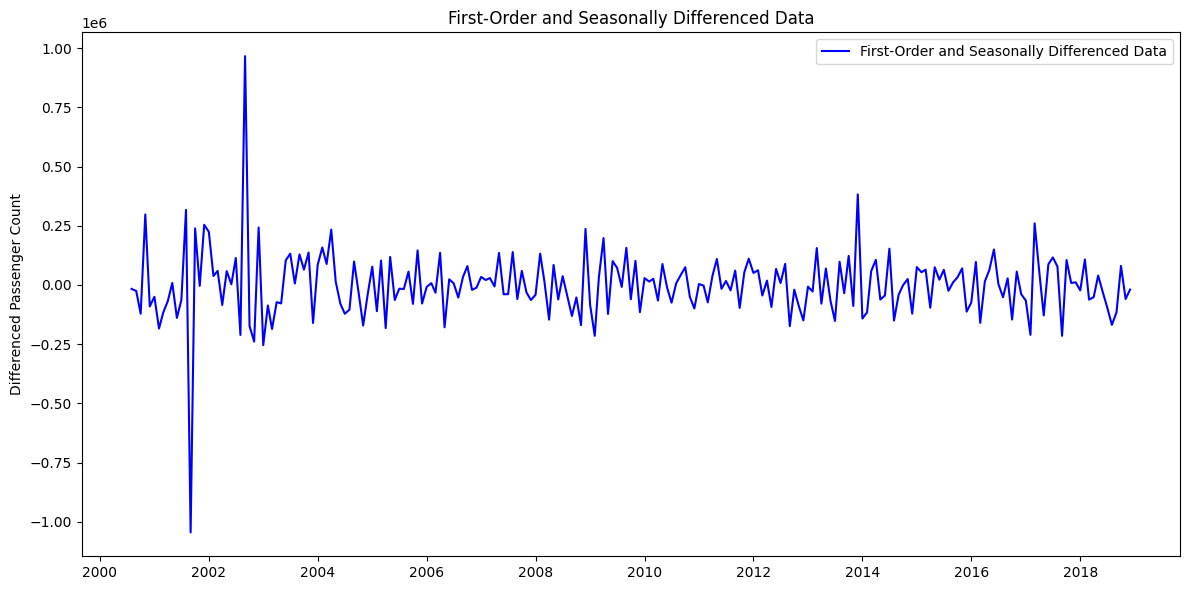

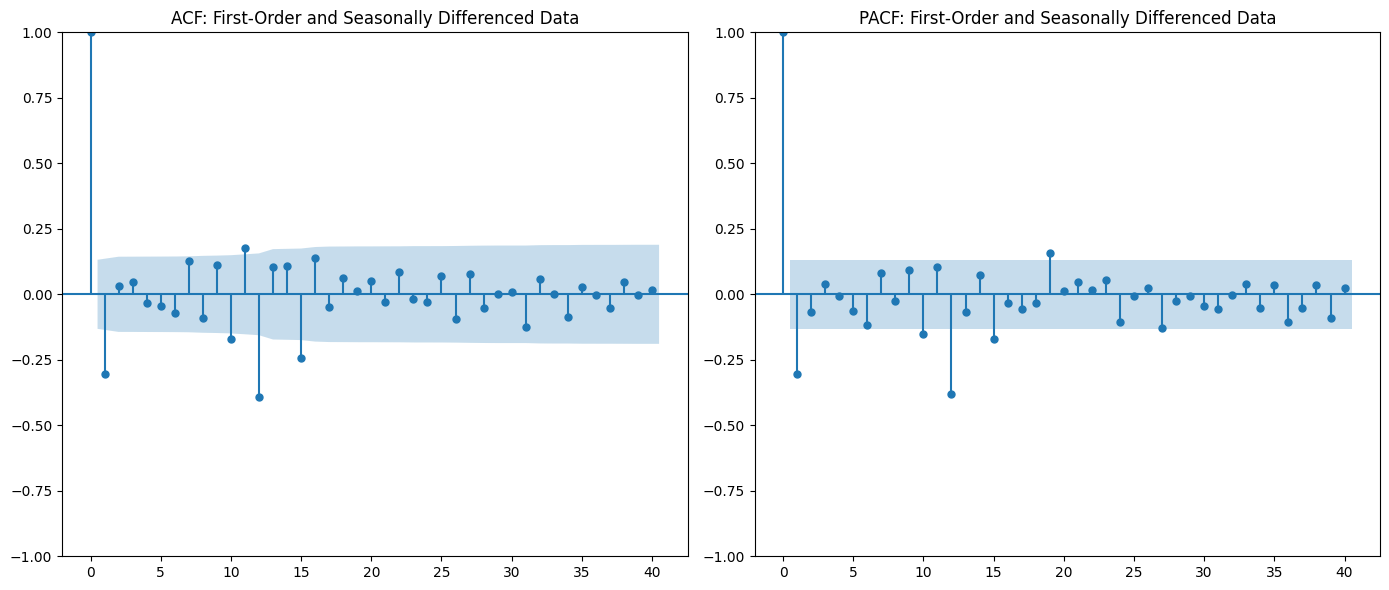

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First-order differencing of seasonally differenced data
df_train['Differenced_1_seasonally'] = df_train['Seasonally Differenced'].diff()

# Drop NaN values caused by differencing
differenced_data_1_seasonally = df_train[['Activity Period Start Date', 'Differenced_1_seasonally']].dropna()

# Plot the first-order and seasonally differenced data
fig, ax = plt.subplots(figsize=(12, 6))  # Create a single figure
ax.plot(differenced_data_1_seasonally['Activity Period Start Date'],
        differenced_data_1_seasonally['Differenced_1_seasonally'],
        label="First-Order and Seasonally Differenced Data", color="blue")
ax.set_title("First-Order and Seasonally Differenced Data")
ax.set_ylabel("Differenced Passenger Count")
ax.legend()

plt.tight_layout()
plt.show()

# ACF and PACF for first-order differenced data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # ACF and PACF side by side

# ACF plot
plot_acf(differenced_data_1_seasonally['Differenced_1_seasonally'], ax=axes[0], lags=40)
axes[0].set_title("ACF: First-Order and Seasonally Differenced Data")

# PACF plot
plot_pacf(differenced_data_1_seasonally['Differenced_1_seasonally'], ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF: First-Order and Seasonally Differenced Data")

plt.tight_layout()
plt.show()

In [ ]:
target_column = "Total Passenger Count (Box-Cox)"

## SARIMA (0,1,0)x(3,1,1)

SARIMA (0,1,0)x(3,1,1):
                                      SARIMAX Results                                       
Dep. Variable:      Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 0)x(3, 1, [1], 12)   Log Likelihood                 835.676
Date:                              Sun, 26 Jan 2025   AIC                          -1661.351
Time:                                      19:19:26   BIC                          -1645.250
Sample:                                           0   HQIC                         -1654.826
                                              - 234                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6489      0.088     -7.403      0.000      -0.821      -0

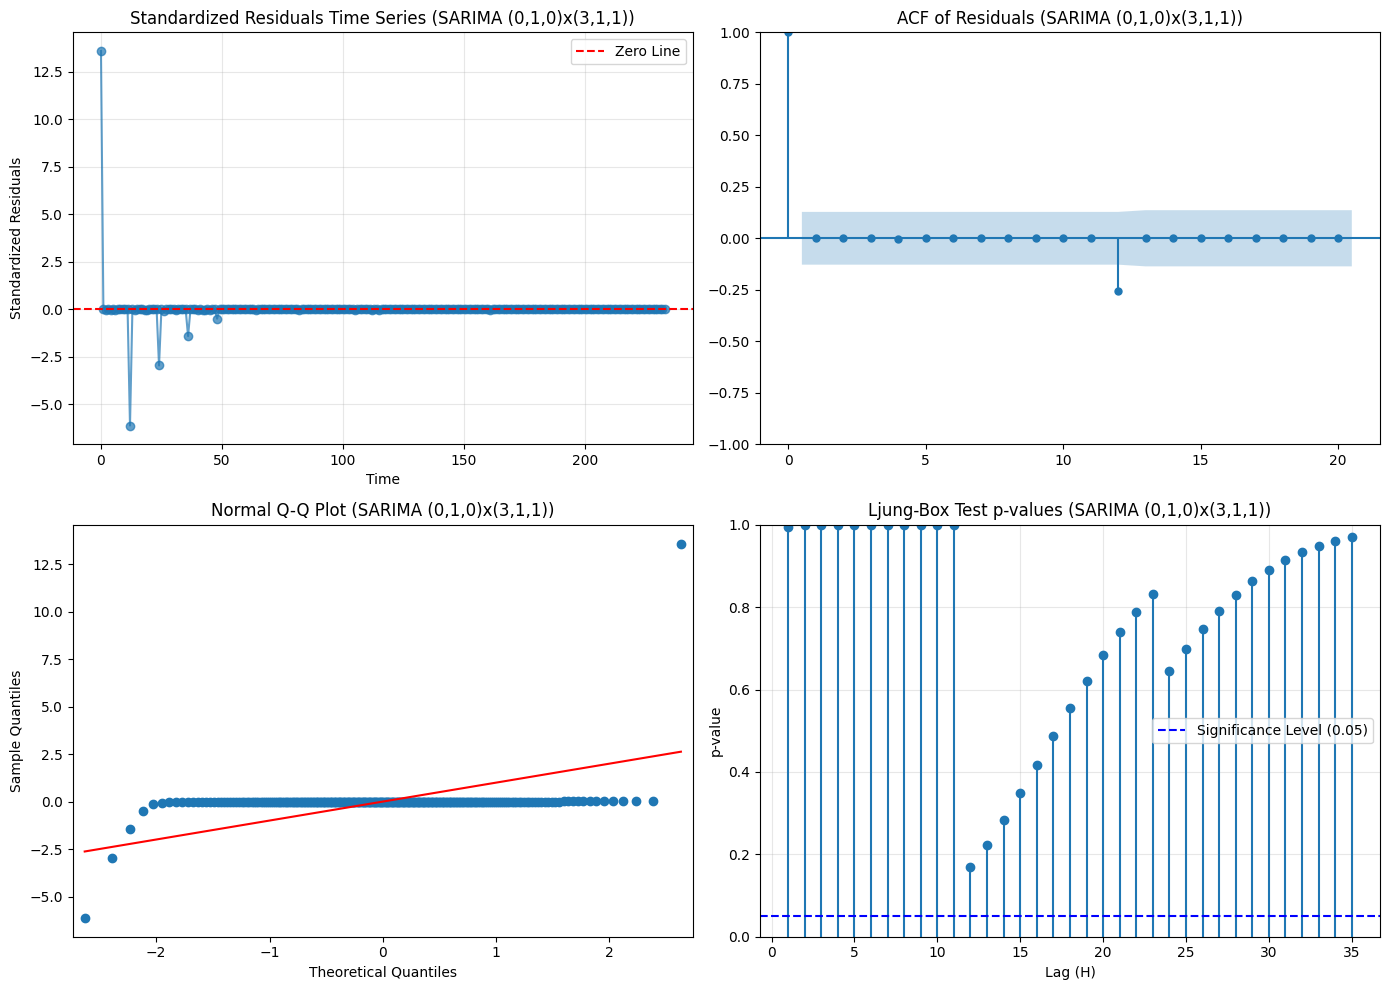

In [ ]:
# SARIMA (0,1,0)x(3,1,1)
sarima_1 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 0),
    seasonal_order=(3, 1, 1, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_1_results = sarima_1.fit(disp=False)
print("SARIMA (0,1,0)x(3,1,1):")
print(sarima_1_results.summary())
plot_diagnostics(sarima_1_results, "SARIMA (0,1,0)x(3,1,1)")

## SARIMA (0,1,1)x(3,1,1)

SARIMA (0,1,1)x(3,1,1):
                                      SARIMAX Results                                      
Dep. Variable:     Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:              SARIMAX(0, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 847.545
Date:                             Sun, 26 Jan 2025   AIC                          -1683.090
Time:                                     19:19:36   BIC                          -1663.768
Sample:                                          0   HQIC                         -1675.259
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3204      0.080     -4.009      0.000      -0.477      -0.164
ar.

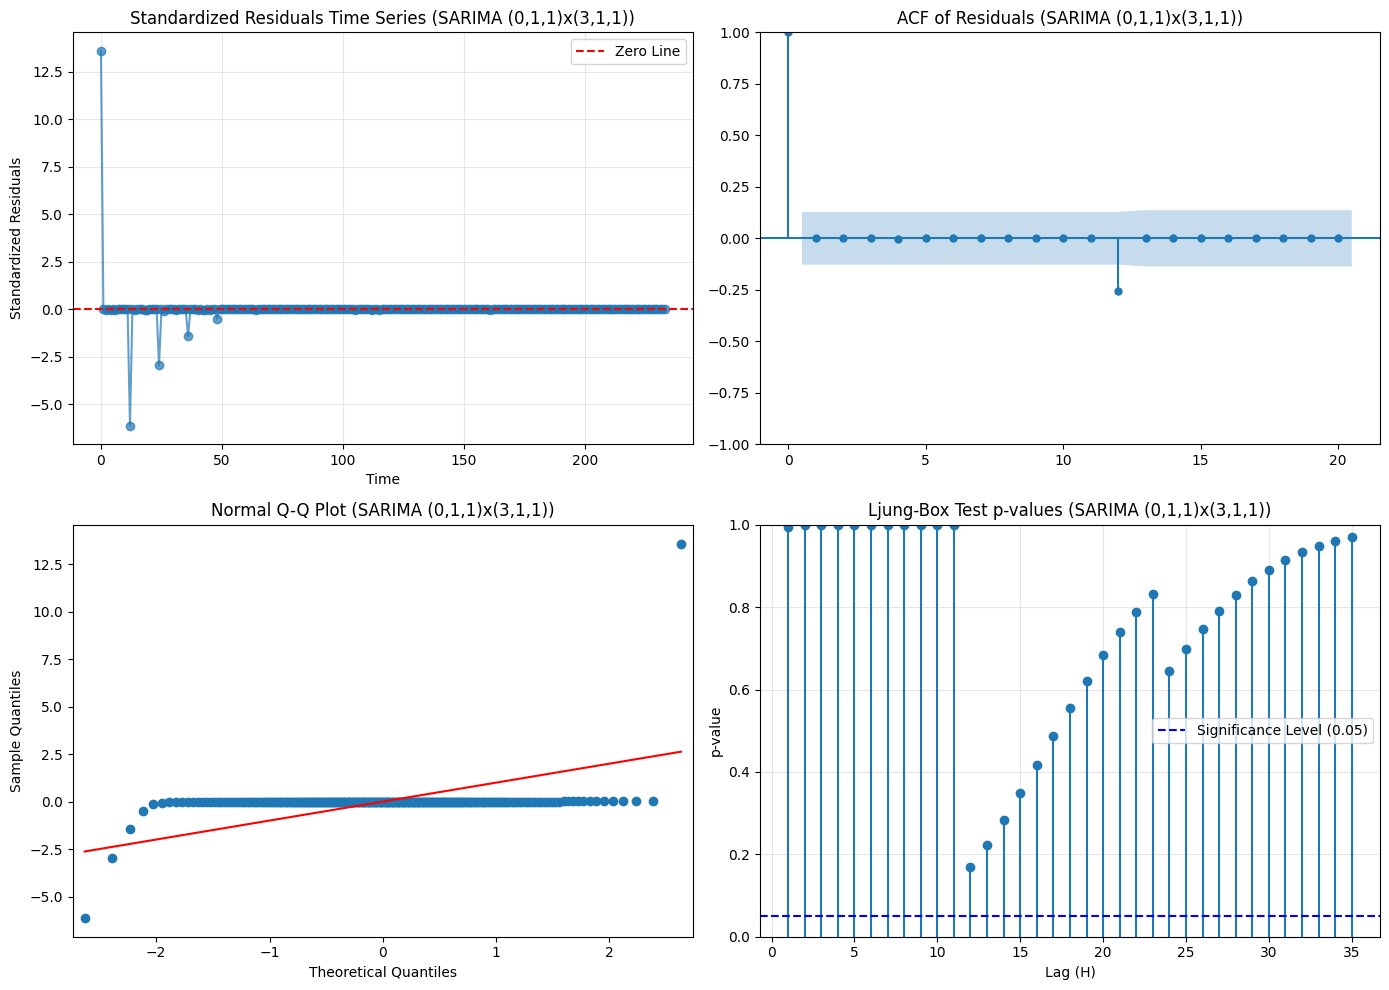

In [ ]:
# SARIMA (0,1,1)x(3,1,1)
sarima_2 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(3, 1, 1, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_2_results = sarima_2.fit(disp=False)
print("SARIMA (0,1,1)x(3,1,1):")
print(sarima_2_results.summary())
plot_diagnostics(sarima_2_results, "SARIMA (0,1,1)x(3,1,1)")

## SARIMA (0,1,0)x(2, 1, 2)

SARIMA (0,1,0)x(2, 1, 2):
                                        SARIMAX Results                                        
Dep. Variable:         Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 0)x(2, 1, [1, 2], 12)   Log Likelihood                 849.824
Date:                                 Sun, 26 Jan 2025   AIC                          -1689.649
Time:                                         19:19:41   BIC                          -1673.258
Sample:                                              0   HQIC                         -1683.013
                                                 - 234                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.5423      0.024    -22.374     

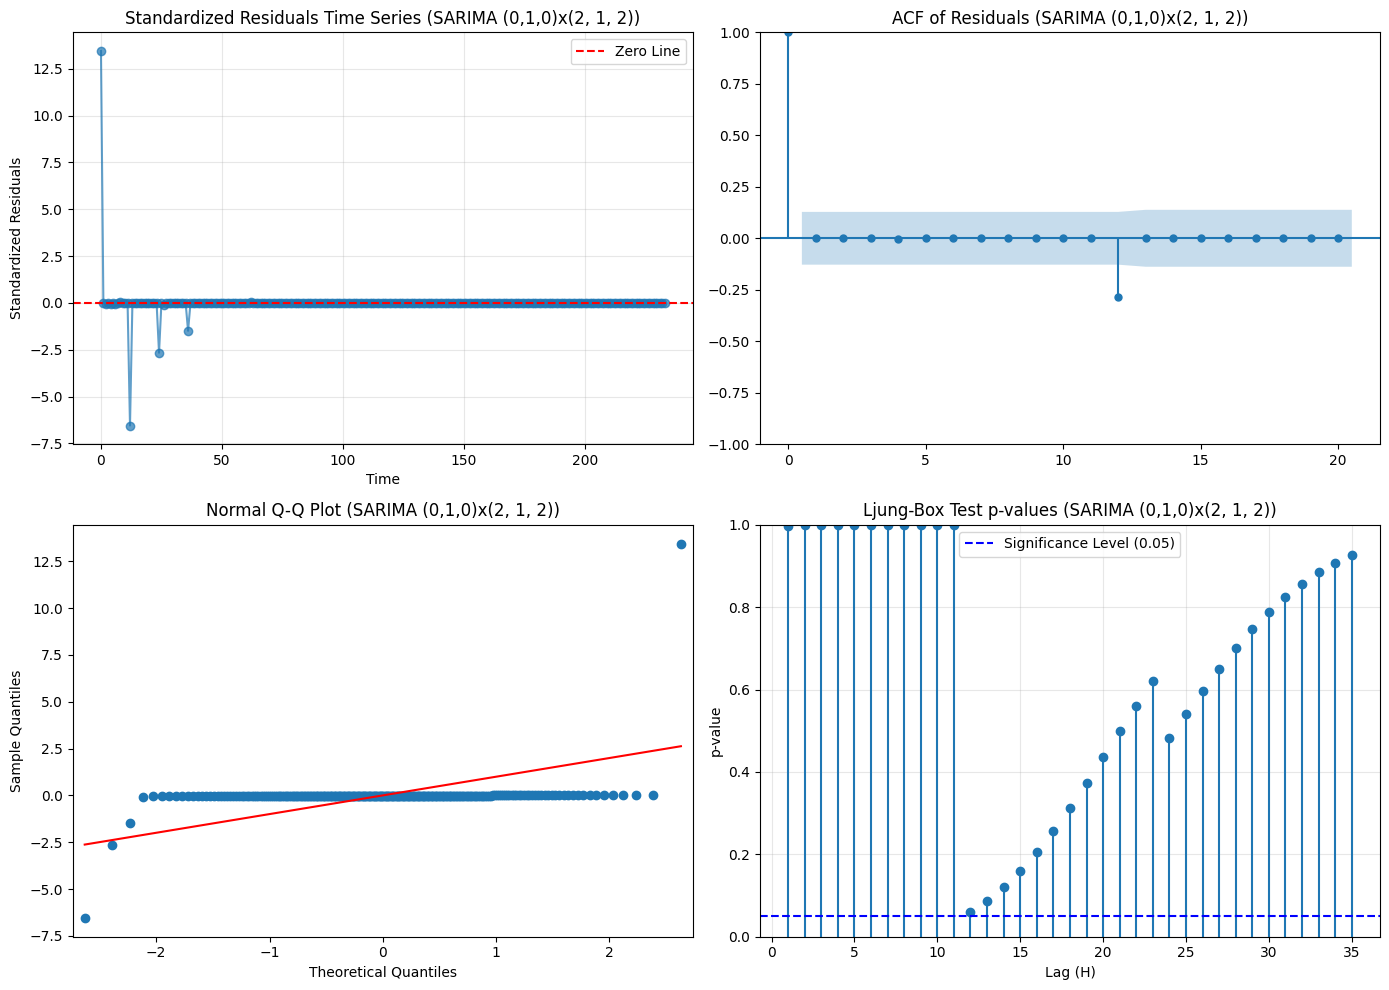

In [ ]:
# SARIMA (0,1,0)x(2, 1, 2)
sarima_1 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 0),
    seasonal_order=(2, 1, 2, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_1_results = sarima_1.fit(disp=False)
print("SARIMA (0,1,0)x(2, 1, 2):")
print(sarima_1_results.summary())
plot_diagnostics(sarima_1_results, "SARIMA (0,1,0)x(2, 1, 2)")

## SARIMA(0,1,1)x(1,1,2)

SARIMA (0,1,1)x(1,1,2):
                                        SARIMAX Results                                        
Dep. Variable:         Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                 871.488
Date:                                 Sun, 26 Jan 2025   AIC                          -1732.977
Time:                                         19:19:53   BIC                          -1716.612
Sample:                                              0   HQIC                         -1726.351
                                                 - 234                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3204      0.047     -6.787      0

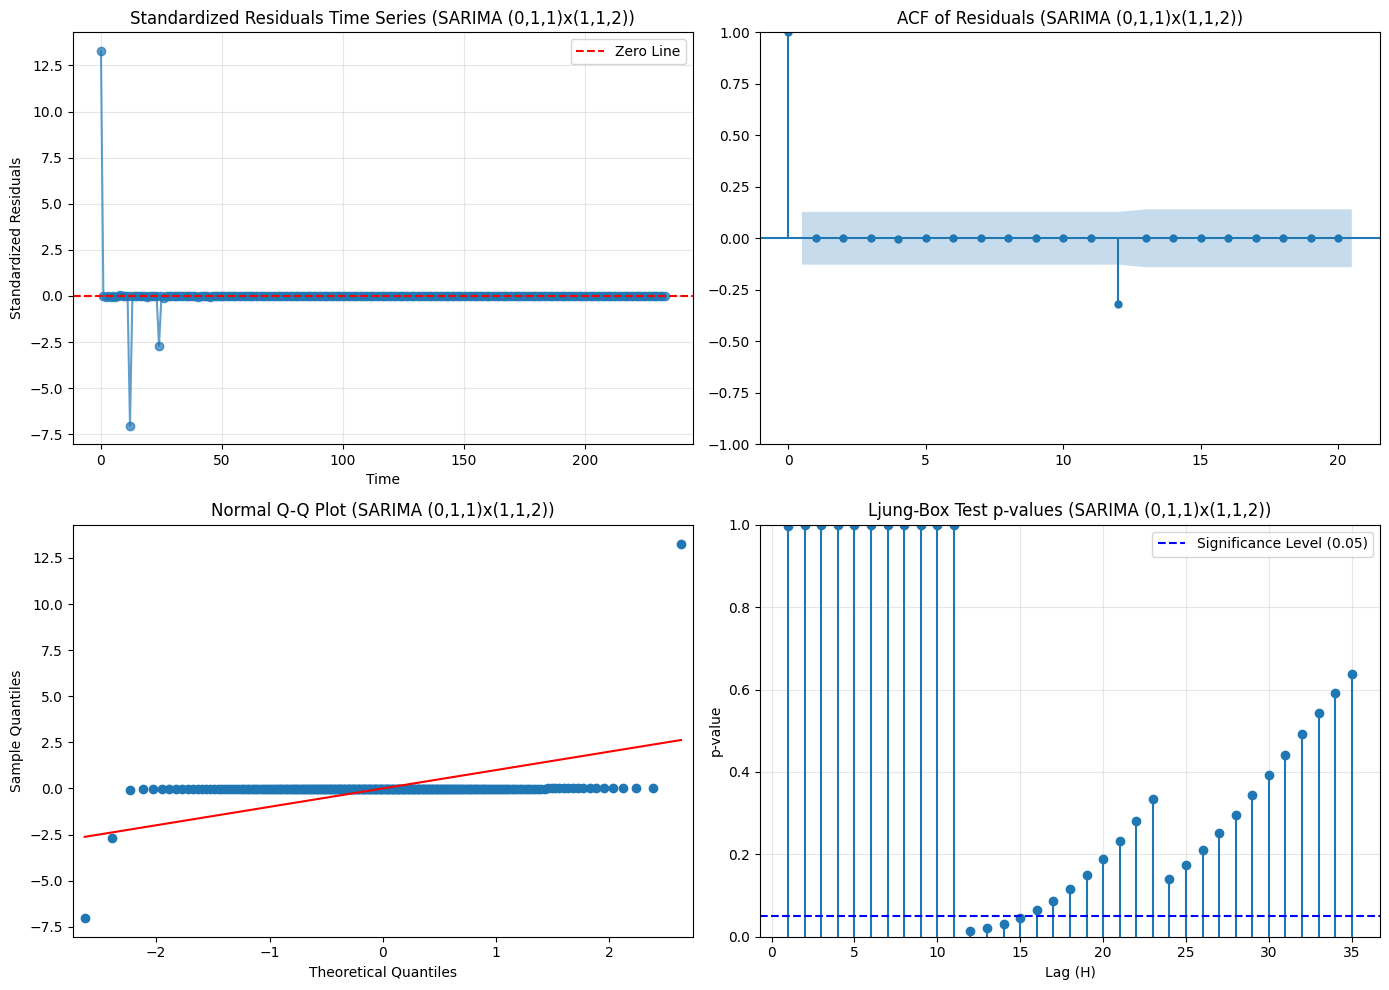

Original parameters: ma.L1      -0.320426
ar.S.L12   -0.417107
ma.S.L12   -0.110664
ma.S.L24   -0.297900
sigma2      0.000008
dtype: float64
SARIMA (0,1,1)x(1,1,2) with ma.S.L12 fixed to 0 (via filter):
                                        SARIMAX Results                                        
Dep. Variable:         Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                 870.065
Date:                                 Sun, 26 Jan 2025   AIC                          -1730.129
Time:                                         19:19:55   BIC                          -1713.764
Sample:                                              0   HQIC                         -1723.503
                                                 - 234                                         
Covariance Type:                                   opg                                         
                 coef    std 

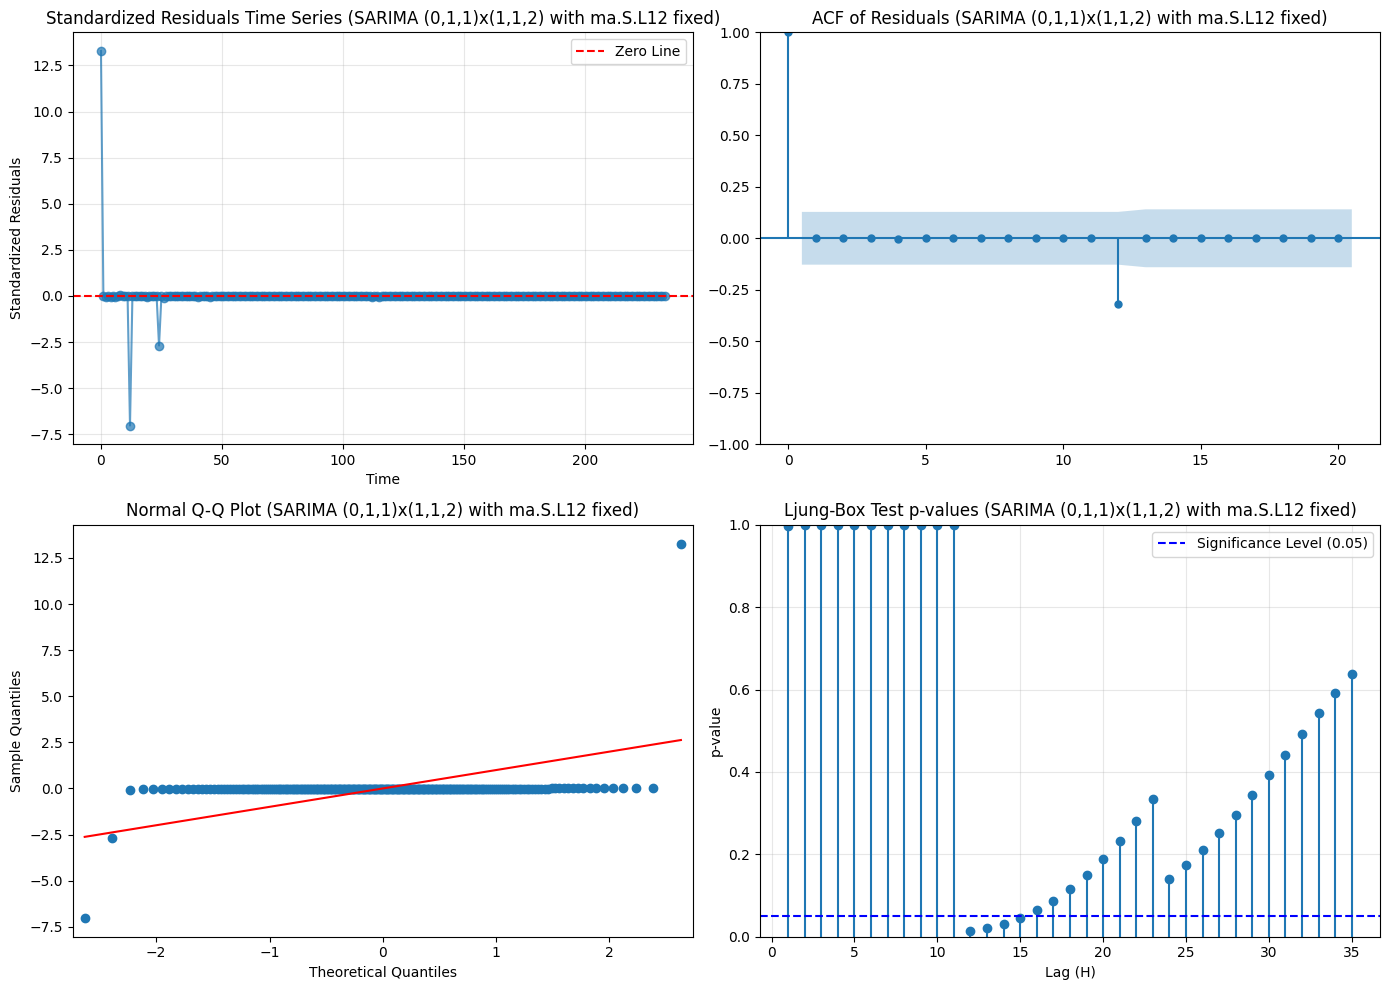

In [ ]:
# SARIMA (0,1,1)x(1,1,2)
sarima_4 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(1, 1, 2, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_4_results = sarima_4.fit(disp=False)
print("SARIMA (0,1,1)x(1,1,2):")
print(sarima_4_results.summary())
plot_diagnostics(sarima_4_results, "SARIMA (0,1,1)x(1,1,2)")

### FIX 2nd Seasonal MA term and get rid of the first one
# Retrieve initial parameters
params = sarima_4_results.params.copy()
print("Original parameters:", params)

# Identify and modify the specific parameter for ma.S.L12
param_names = sarima_4.param_names
ma_S_L12_index = param_names.index('ma.S.L12')
params[ma_S_L12_index] = 0  # Set ma.S.L12 to zero

# Apply filter with the modified parameters
filtered_results = sarima_4.filter(params)

# Print summary of the modified results
print("SARIMA (0,1,1)x(1,1,2) with ma.S.L12 fixed to 0 (via filter):")
print(filtered_results.summary())

# Plot diagnostics for the filtered results
plot_diagnostics(filtered_results, "SARIMA (0,1,1)x(1,1,2) with ma.S.L12 fixed")

## SARIMA (0,1,1)x(2,0,2)

SARIMA (0,1,1)x(2,0,2):
                                        SARIMAX Results                                        
Dep. Variable:         Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 925.799
Date:                                 Sun, 26 Jan 2025   AIC                          -1839.597
Time:                                         19:20:00   BIC                          -1819.601
Sample:                                              0   HQIC                         -1831.511
                                                 - 234                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2438      0.047     -5.207      0

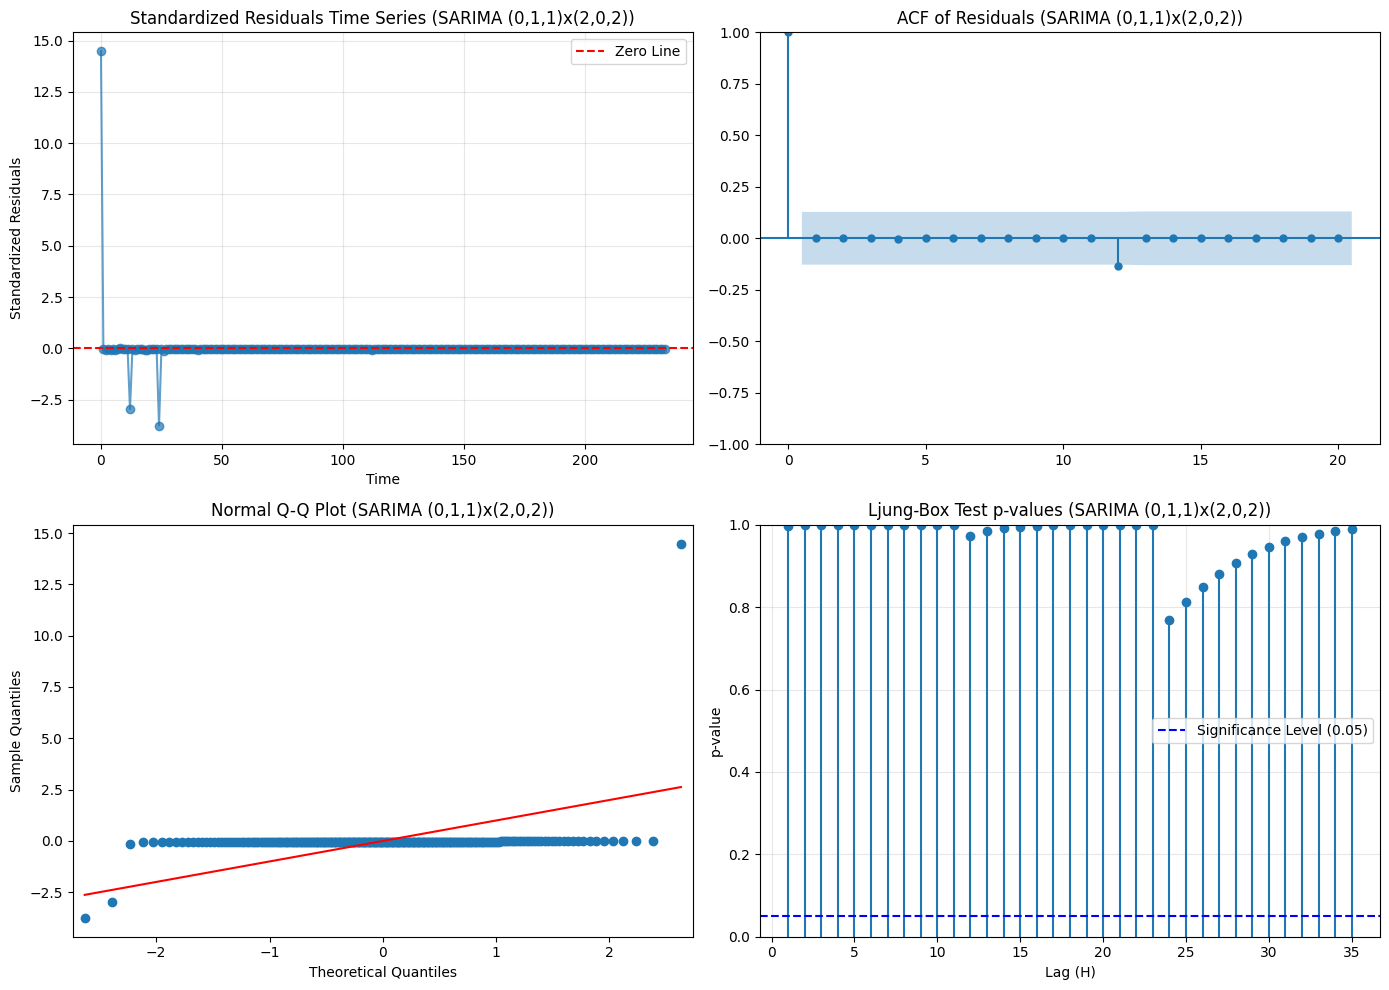

Original parameters: ma.L1      -0.243809
ar.S.L12    0.403598
ar.S.L24    0.553789
ma.S.L12   -0.082132
ma.S.L24   -0.481755
sigma2      0.000007
dtype: float64
SARIMA (0,1,1)x(2,0,2) with ma.S.L12 fixed to 0 (via filter):
                                        SARIMAX Results                                        
Dep. Variable:         Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 925.351
Date:                                 Sun, 26 Jan 2025   AIC                          -1838.701
Time:                                         19:20:01   BIC                          -1818.705
Sample:                                              0   HQIC                         -1830.615
                                                 - 234                                         
Covariance Type:                                   opg                                         
        

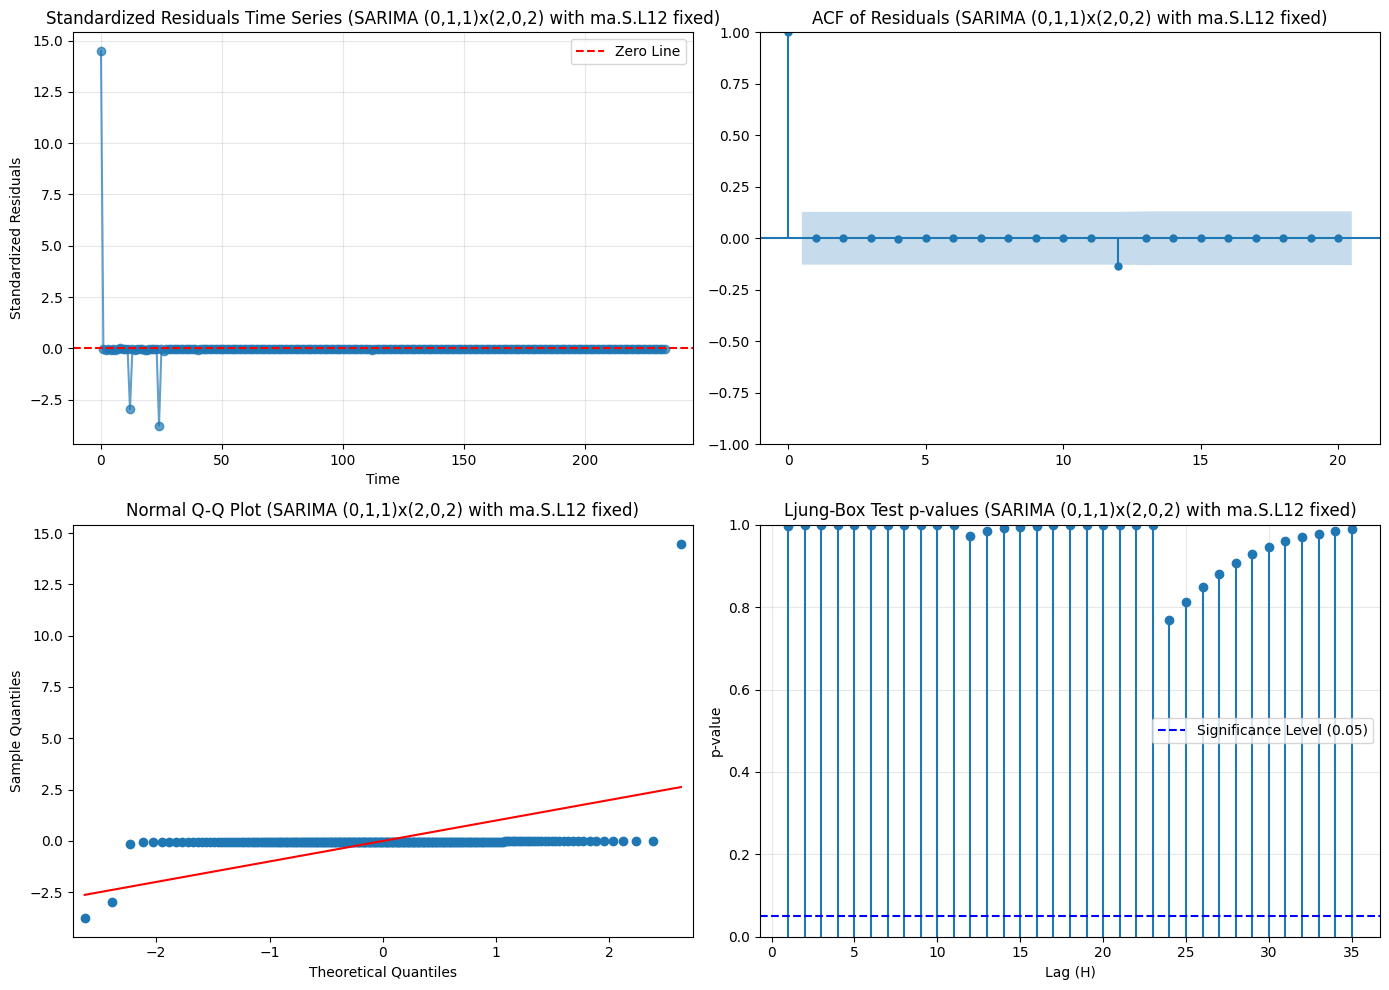

In [ ]:
# SARIMA (0,1,1)x(2,0,2)
sarima_5 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(2, 0, 2, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_5_results = sarima_5.fit(disp=False)
print("SARIMA (0,1,1)x(2,0,2):")
print(sarima_5_results.summary())
plot_diagnostics(sarima_5_results, "SARIMA (0,1,1)x(2,0,2)")

### FIX 2nd Seasonal MA term and get rid of the first one
# Retrieve initial parameters
params = sarima_5_results.params.copy()
print("Original parameters:", params)

# Identify and modify the specific parameter for ma.S.L12
param_names = sarima_5.param_names
ma_S_L12_index = param_names.index('ma.S.L12')
params[ma_S_L12_index] = 0  # Set ma.S.L12 to zero

# Apply filter with the modified parameters
filtered_results = sarima_5.filter(params)

# Print summary of the modified results
print("SARIMA (0,1,1)x(2,0,2) with ma.S.L12 fixed to 0 (via filter):")
print(filtered_results.summary())

# Plot diagnostics for the filtered results
plot_diagnostics(filtered_results, "SARIMA (0,1,1)x(2,0,2) with ma.S.L12 fixed")

## Using Log instead of Box-Cox Transformation

In [ ]:
# Extract the 'Total Passenger Count' column
total_passenger_count = df_train['Total Passenger Count']

# Apply the log transformation
df_train['Total Passenger Count (Log)'] = np.log(total_passenger_count + 1)  # Adding 1 to avoid log(0) issues

In [ ]:
target_column = "Total Passenger Count (Log)"

SARIMA (0,1,0)x(3,1,1) with log:
                                      SARIMAX Results                                       
Dep. Variable:          Total Passenger Count (Log)   No. Observations:                  234
Model:             SARIMAX(0, 1, 0)x(3, 1, [1], 12)   Log Likelihood                 401.832
Date:                              Sun, 26 Jan 2025   AIC                           -793.665
Time:                                      19:20:06   BIC                           -777.563
Sample:                                           0   HQIC                          -787.139
                                              - 234                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0492      0.050     -0.981      0.327      -0.14

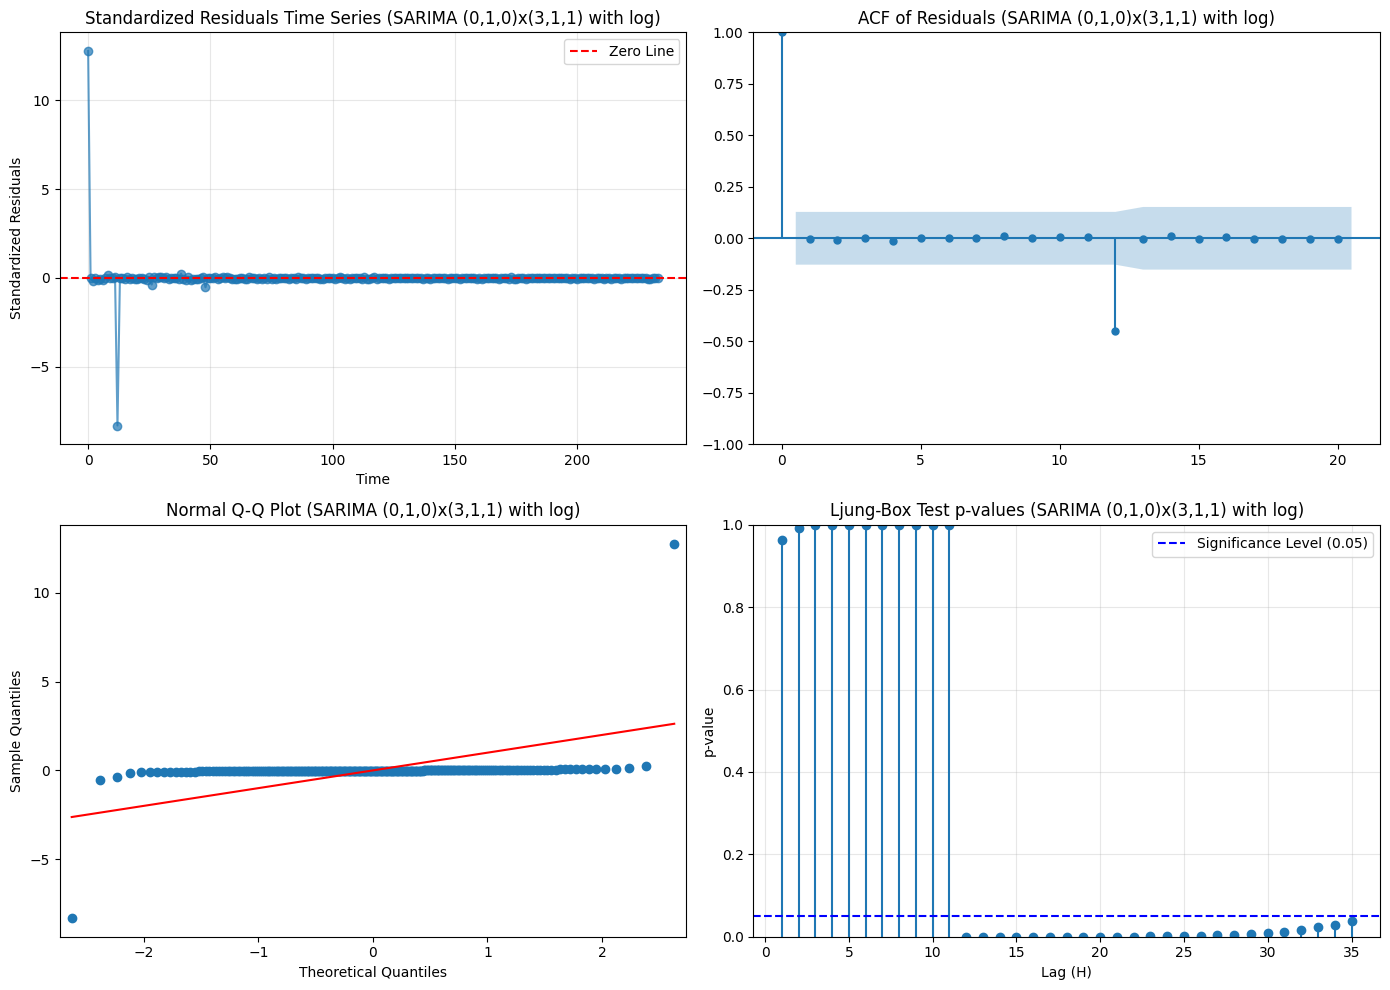

In [ ]:
# SARIMA (0,1,0)x(3,1,1)
sarima_1_log = SARIMAX(
    df_train[target_column],
    order=(0, 1, 0),
    seasonal_order=(3, 1, 1, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_1_results_log = sarima_1_log.fit(disp=False)
print("SARIMA (0,1,0)x(3,1,1) with log:")
print(sarima_1_results_log.summary())
plot_diagnostics(sarima_1_results_log, "SARIMA (0,1,0)x(3,1,1) with log")

SARIMA (0,1,1)x(3,1,1) with log:
                                     SARIMAX Results                                      
Dep. Variable:        Total Passenger Count (Log)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(3, 1, 1, 12)   Log Likelihood                 409.434
Date:                            Sun, 26 Jan 2025   AIC                           -806.868
Time:                                    19:20:11   BIC                           -787.545
Sample:                                         0   HQIC                          -799.037
                                            - 234                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3569      0.079     -4.543      0.000      -0.511      -0.203
ar

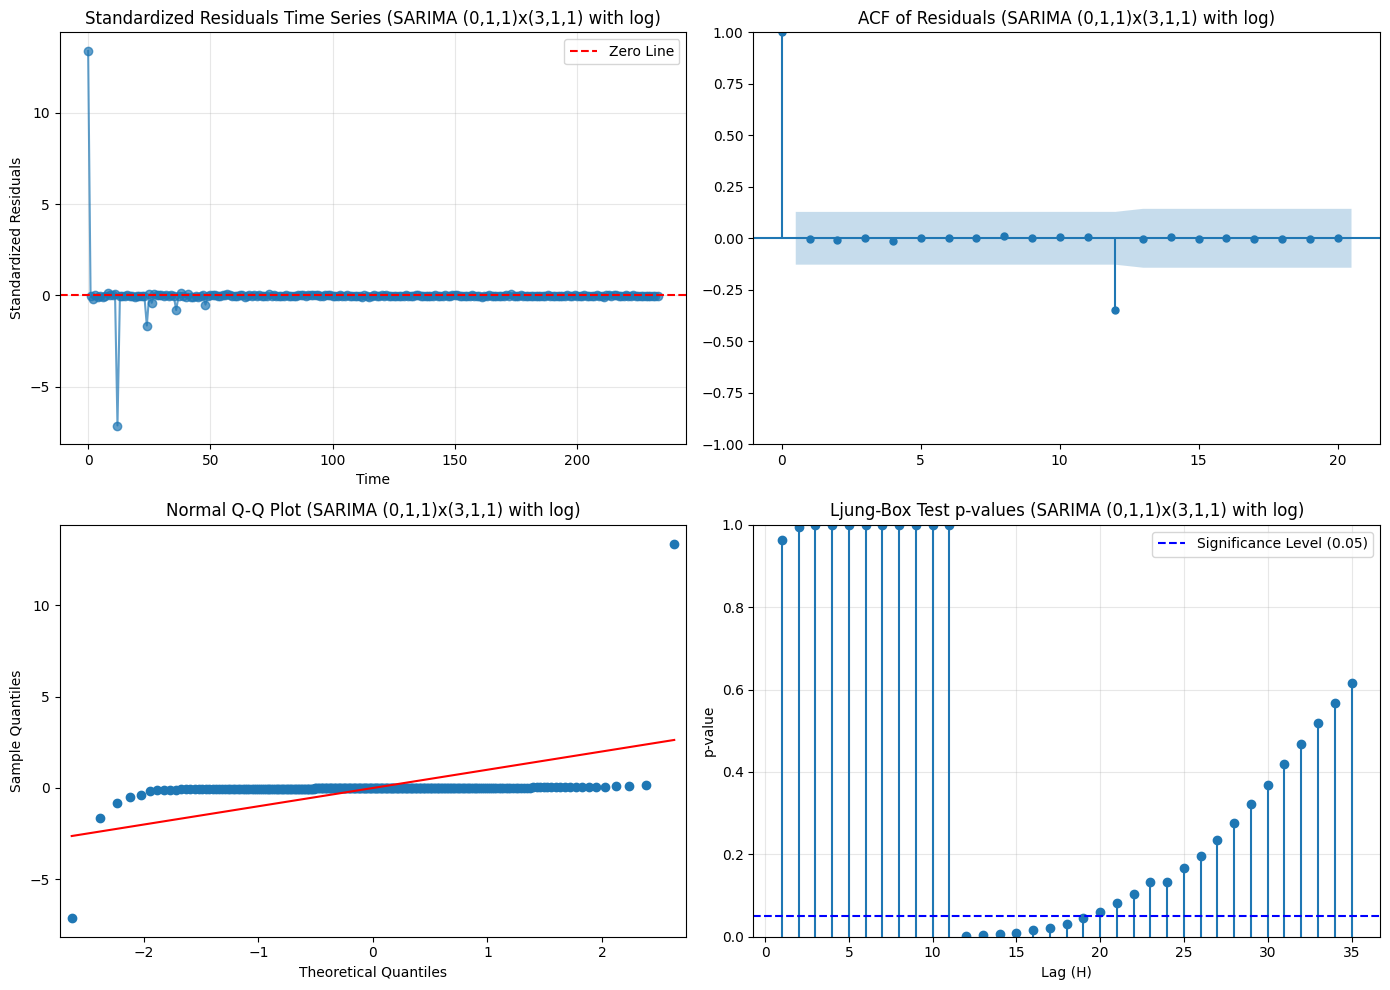

In [ ]:
# SARIMA (0,1,1)x(3,1,1)
sarima_2_log = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(3, 1, 1, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_2_results_log = sarima_2_log.fit(disp=False)
print("SARIMA (0,1,1)x(3,1,1) with log:")
print(sarima_2_results_log.summary())
plot_diagnostics(sarima_2_results_log, "SARIMA (0,1,1)x(3,1,1) with log")

Log-Transform did not improve the Q-Q plot of our good models and we would need a much larger model to get rid of the Ljung-Box Test significant correlations, leading to a higher AIC score and still non-normally distributed residuals - so we will keep on working with the Box-cox transformed data

SARIMA (0,1,1)x(5,1,1) with log:
                                      SARIMAX Results                                      
Dep. Variable:         Total Passenger Count (Log)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood                 380.357
Date:                             Sun, 26 Jan 2025   AIC                           -746.715
Time:                                     19:20:21   BIC                           -725.145
Sample:                                          0   HQIC                          -737.957
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3991      0.070     -5.715      0.000      -0.536      -

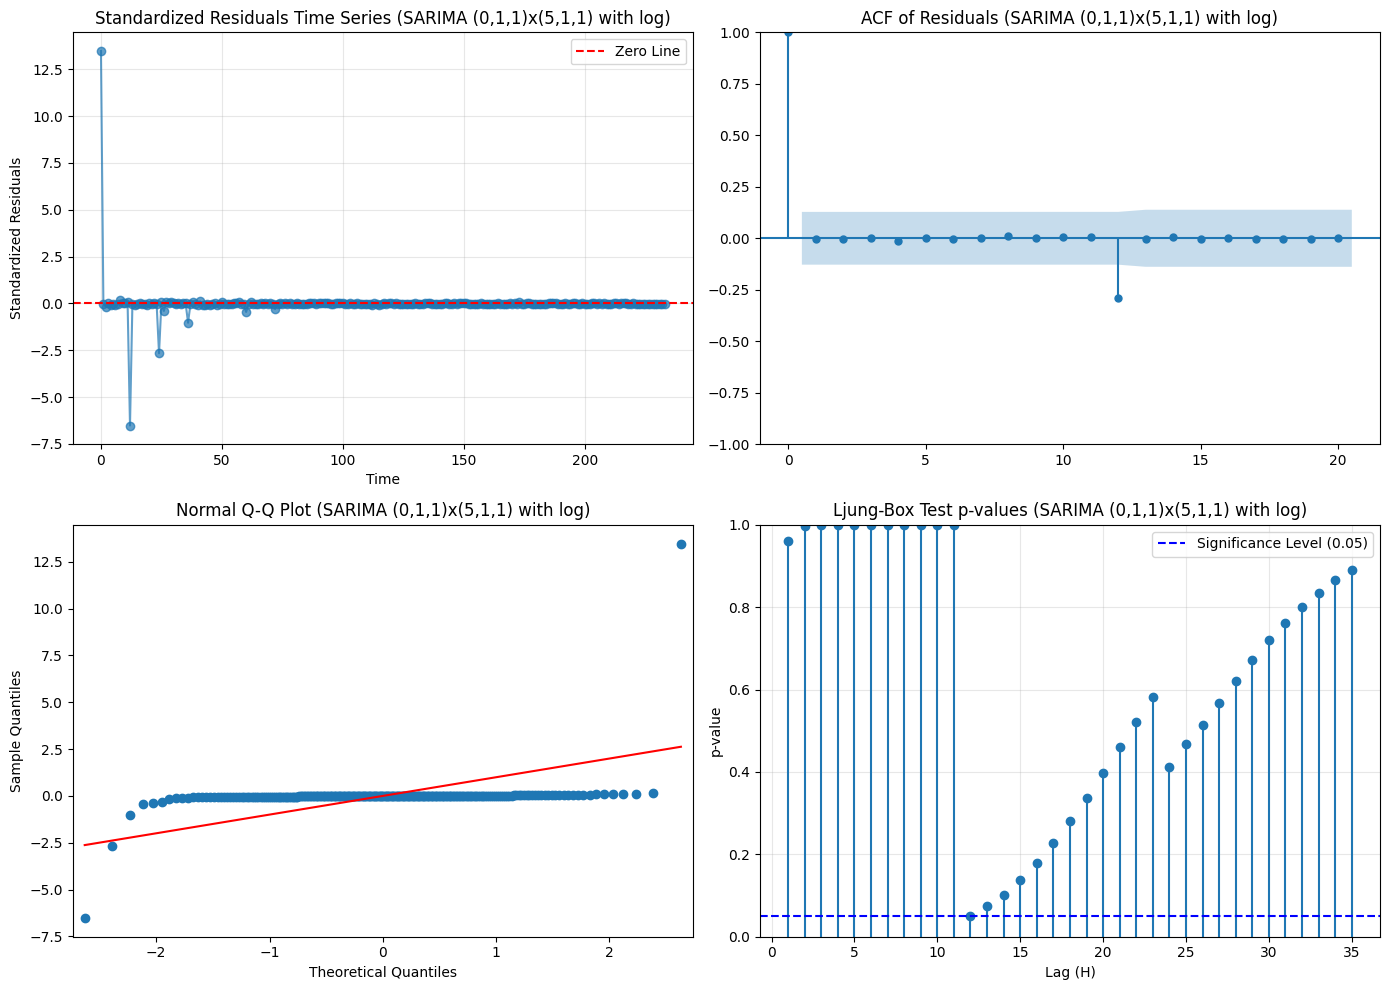

In [ ]:
# SARIMA (0,1,1)x(5,1,1)
sarima_3_log = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(5, 1, 0, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_3_results_log = sarima_3_log.fit(disp=False)
print("SARIMA (0,1,1)x(5,1,1) with log:")
print(sarima_3_results_log.summary())
plot_diagnostics(sarima_3_results_log, "SARIMA (0,1,1)x(5,1,1) with log")

In [ ]:
target_column = "Total Passenger Count (Box-Cox)"

SARIMA (0,1,0)x(3,2,1):
                                      SARIMAX Results                                       
Dep. Variable:      Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 0)x(3, 2, [1], 12)   Log Likelihood                 746.365
Date:                              Sun, 26 Jan 2025   AIC                          -1482.730
Time:                                      19:20:25   BIC                          -1466.964
Sample:                                           0   HQIC                         -1476.334
                                              - 234                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.0146      0.079    -12.780      0.000      -1.170      -0

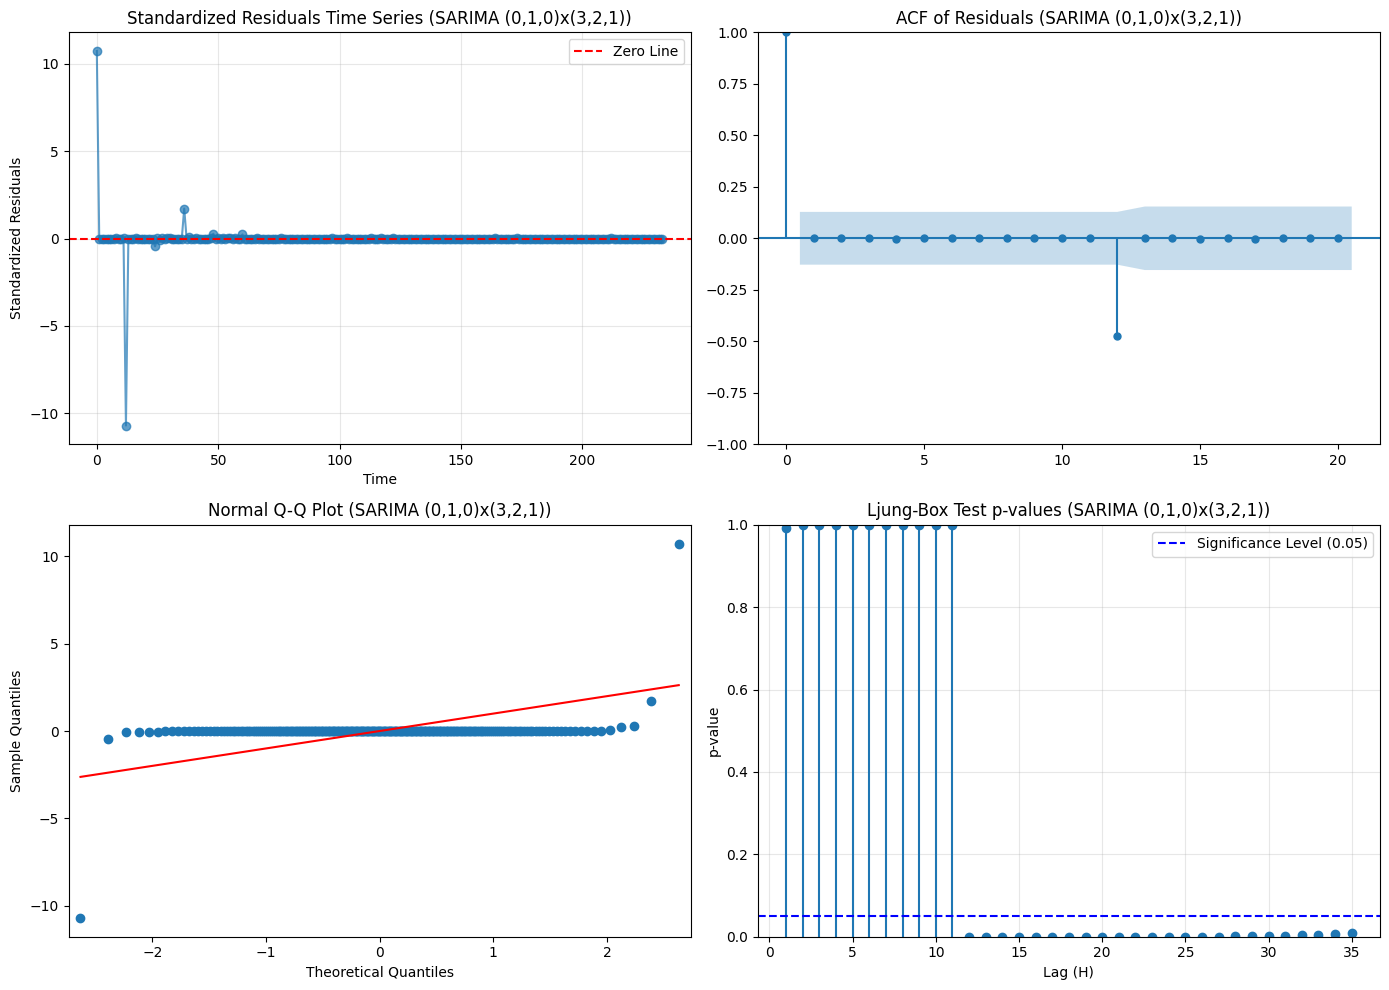

In [ ]:
# SARIMA (0,1,0)x(3,2,0)
sarima_4 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 0),
    seasonal_order=(3, 2, 1, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_4_results = sarima_4.fit(disp=False)
print("SARIMA (0,1,0)x(3,2,1):")
print(sarima_4_results.summary())
plot_diagnostics(sarima_4_results, "SARIMA (0,1,0)x(3,2,1)")

SARIMA (0,1,0)x(3,2,0):
                                      SARIMAX Results                                      
Dep. Variable:     Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:              SARIMAX(0, 1, 0)x(3, 2, 0, 12)   Log Likelihood                 750.500
Date:                             Sun, 26 Jan 2025   AIC                          -1492.999
Time:                                     19:20:29   BIC                          -1480.386
Sample:                                          0   HQIC                         -1487.882
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.8961      0.051    -17.722      0.000      -0.995      -0.797
ar.

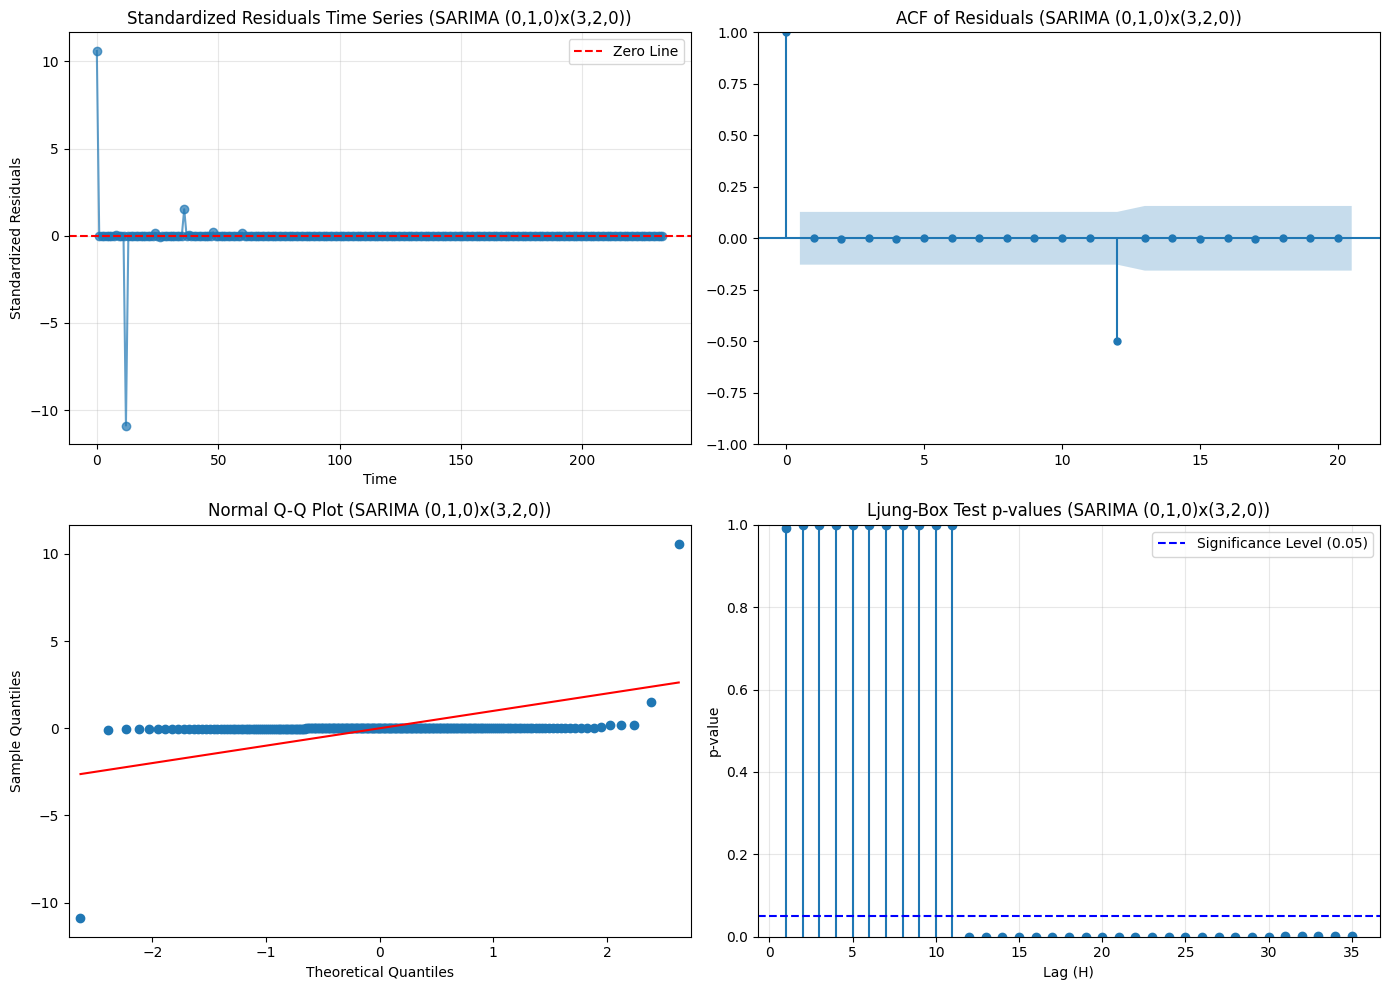

In [ ]:
# SARIMA (0,1,0)x(3,2,0)
sarima_4 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 0),
    seasonal_order=(3, 2, 0, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_4_results = sarima_4.fit(disp=False)
print("SARIMA (0,1,0)x(3,2,0):")
print(sarima_4_results.summary())
plot_diagnostics(sarima_4_results, "SARIMA (0,1,0)x(3,2,0)")

SARIMA (0,1,0)x(4,2,0):
                                      SARIMAX Results                                      
Dep. Variable:     Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:              SARIMAX(0, 1, 0)x(4, 2, 0, 12)   Log Likelihood                 712.359
Date:                             Sun, 26 Jan 2025   AIC                          -1414.718
Time:                                     19:20:34   BIC                          -1399.311
Sample:                                          0   HQIC                         -1408.462
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.0487      0.067    -15.668      0.000      -1.180      -0.917
ar.

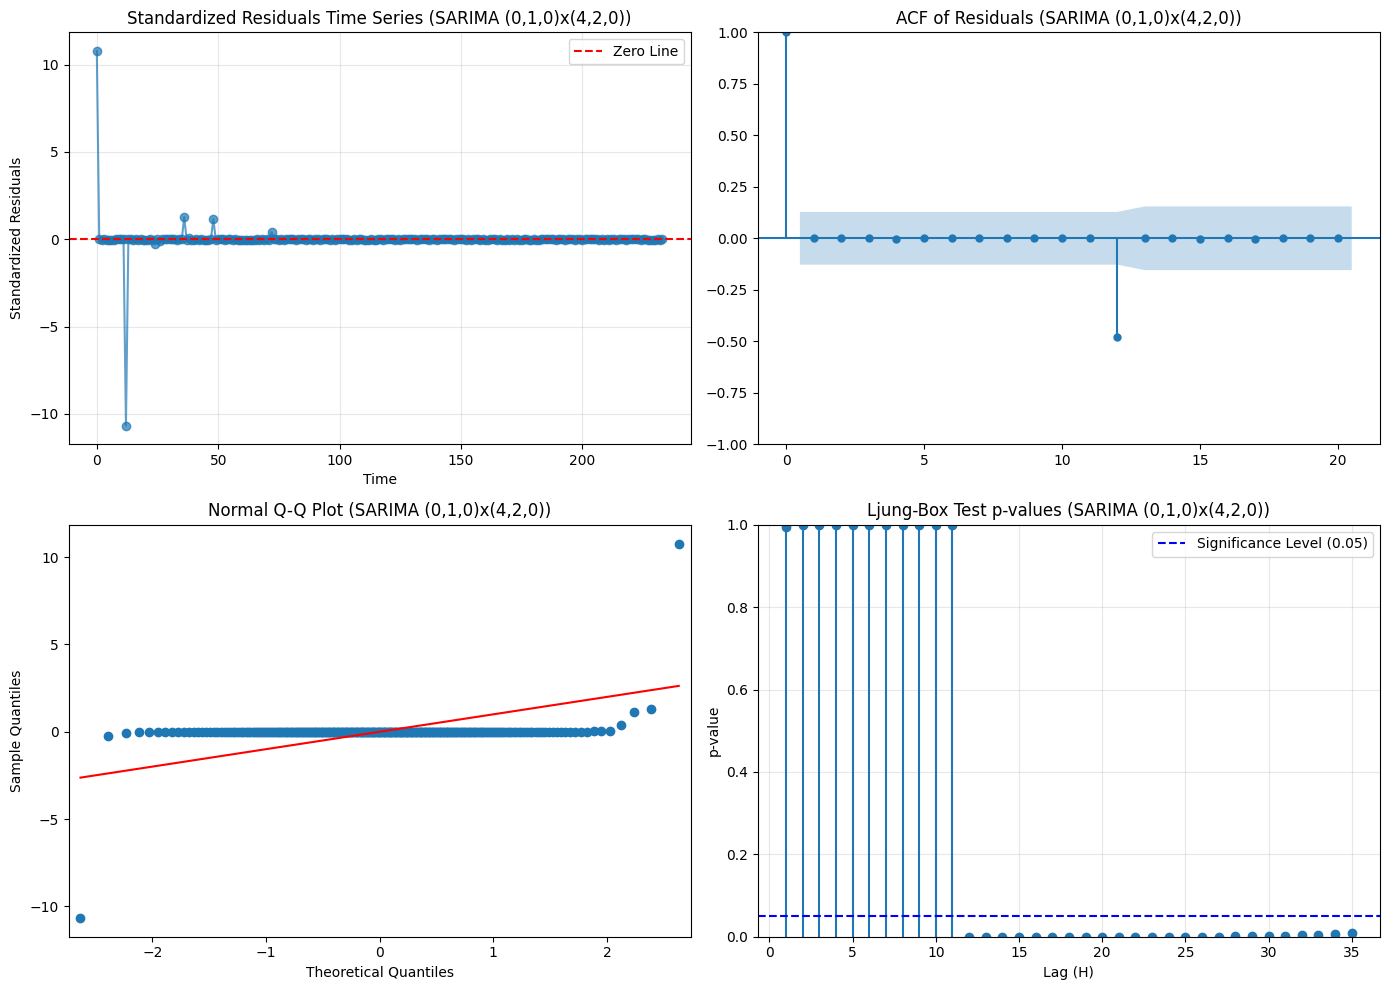

In [ ]:
# SARIMA (0,1,0)x(4,2,0)
sarima_4 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 0),
    seasonal_order=(4, 2, 0, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_4_results = sarima_4.fit(disp=False)
print("SARIMA (0,1,0)x(4,2,0):")
print(sarima_4_results.summary())
plot_diagnostics(sarima_4_results, "SARIMA (0,1,0)x(4,2,0)")

SARIMA (0,1,1)x(4,2,0):
                                      SARIMAX Results                                      
Dep. Variable:     Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(4, 2, [], 12)   Log Likelihood                 724.946
Date:                             Sun, 26 Jan 2025   AIC                          -1437.891
Time:                                     19:20:37   BIC                          -1419.403
Sample:                                          0   HQIC                         -1430.384
                                             - 234                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2892      0.069     -4.189      0.000      -0.425      -0.154
ar.

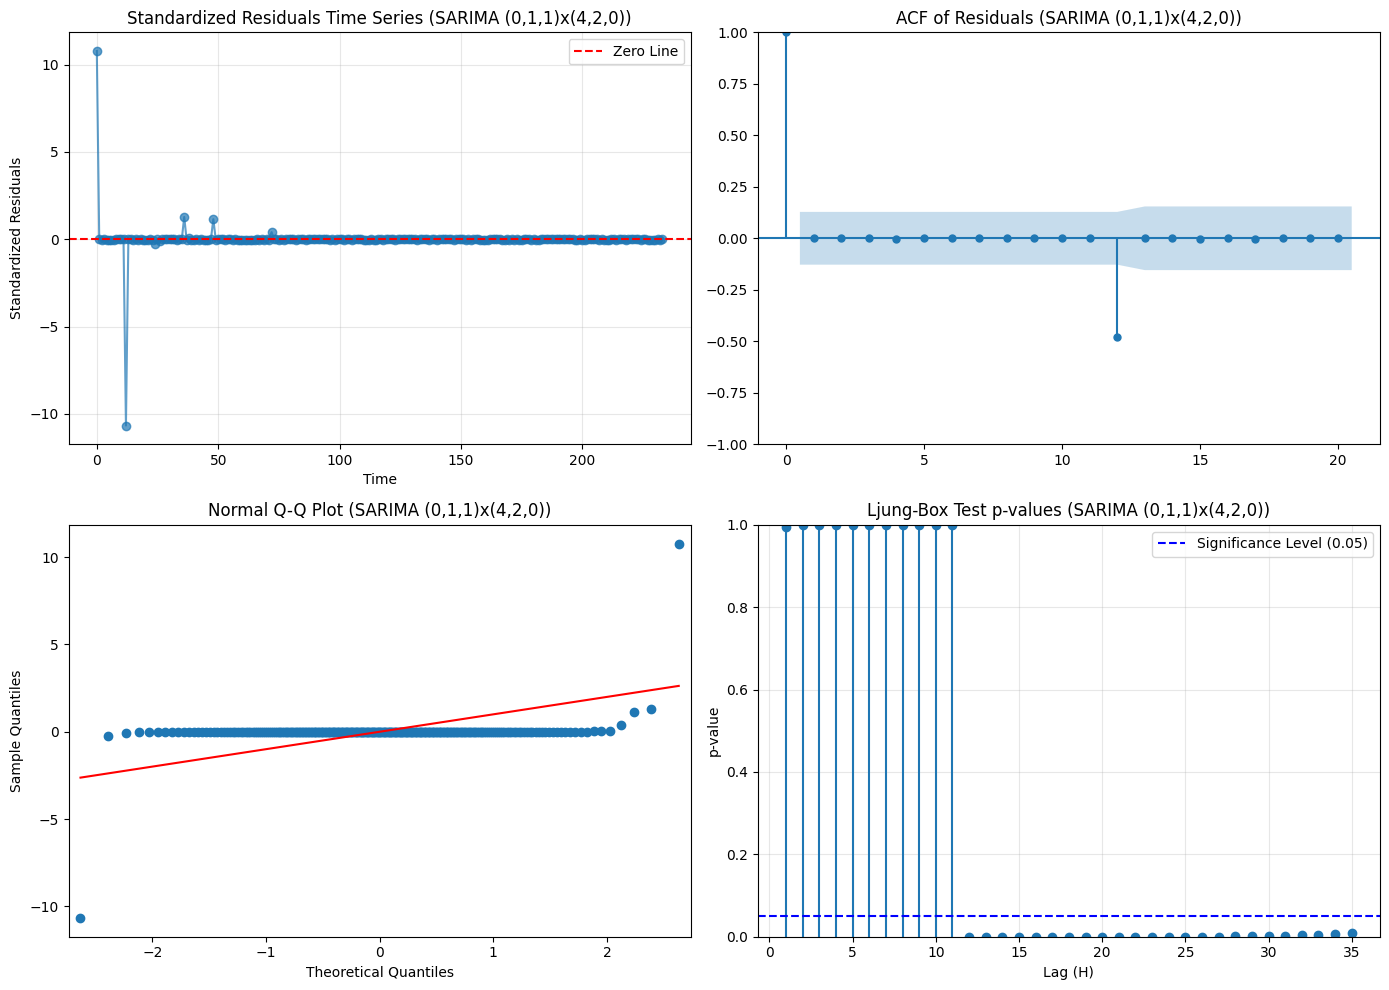

In [ ]:
# SARIMA (0,1,1)x(4,2,0)
sarima_4 = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(4, 2, 0, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_4_results = sarima_4.fit(disp=False)
print("SARIMA (0,1,1)x(4,2,0):")
print(sarima_4_results.summary())
plot_diagnostics(sarima_4_results, "SARIMA (0,1,1)x(4,2,0)")

## Auto ARIMA - SARIMA(0,1,1)×(2,0,2)

In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt

In [ ]:
target_column = "Total Passenger Count (Box-Cox)"

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

# Define your data (assuming df_train[target_column] contains your time series)
# Example:
# df_train = pd.read_csv('your_data.csv')
# target_column = 'your_target_column'

# Set the parameter ranges
p_values = range(0, 4)  # p = 0, 1, 2, 3
d_values = range(0, 2)  # d = 0, 1
q_values = range(0, 4)  # q = 0, 1, 2, 3
P_values = range(0, 4)  # P = 0, 1, 2, 3
D_values = range(0, 2)  # D = 0, 1
Q_values = range(0, 4)  # Q = 0, 1, 2, 3
m = 12  # Period for seasonality (e.g., 12 for monthly data with yearly seasonality)

# Initialize a list to store results
results = []

# Loop through all combinations of parameters within their respective ranges
for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        try:
                            start_time = time.time()  # Start the timer

                            # Fit the SARIMA model with the current combination of parameters
                            sarima = SARIMAX(
                                df_train[target_column],
                                order=(p, d, q),  # Non-seasonal (p, d, q)
                                seasonal_order=(P, D, Q, m),  # Seasonal (P, D, Q, m)
                                enforce_stationarity=False,  # Allow for non-stationarity
                                enforce_invertibility=False  # Allow for non-invertibility
                            )
                            sarima_results = sarima.fit(disp=False)  # Fit the model

                            # Calculate the time taken for fitting
                            end_time = time.time() - start_time

                            # Print the progress in the desired format
                            print(f"ARIMA({p},{d},{q})({P},{D},{Q})[{m}] intercept   : AIC={sarima_results.aic:.3f}, Time={end_time:.2f} sec")

                            # Store the model summary and AIC for analysis
                            results.append({
                                'p': p,
                                'd': d,
                                'q': q,
                                'P': P,
                                'D': D,
                                'Q': Q,
                                'AIC': sarima_results.aic,
                                'Model Summary': sarima_results.summary()
                            })

                        except Exception as e:
                            # If an error occurs (e.g., model doesn't converge), skip that combination
                            print(f"Error with parameters (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")
                            continue

# Convert results to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Print the results DataFrame
print(results_df)

ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1474.196, Time=0.02 sec
ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1141.010, Time=0.10 sec
ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=999.411, Time=1.07 sec
ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=885.420, Time=3.04 sec
ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-1488.131, Time=0.05 sec
ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=-1403.202, Time=0.31 sec
ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=-1440.474, Time=1.02 sec
ARIMA(0,0,0)(0,1,3)[12] intercept   : AIC=-1427.611, Time=5.71 sec
ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-1502.879, Time=0.10 sec
ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-1493.342, Time=0.31 sec
ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=-1407.767, Time=0.89 sec
ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=-1554.172, Time=1.51 sec
ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=-1408.797, Time=0.08 sec
ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=-1421.372, Time=0.72 sec
ARIMA(0,0,0)(1,1,2)[12] intercept   : AIC=-1446.513, Time=1.67 sec
A

In [ ]:
import pandas as pd

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save to a CSV file
results_df.to_csv('sarima_results.csv', index=False)

print("Results saved to 'sarima_results.csv'")

Results saved to 'sarima_results.csv'


In [ ]:
# Initialize variables to store the best model
best_aic = float('inf')  # Initialize to a large value
best_model = None
best_model_summary = None
best_params = {}

# Loop through stored models and select the best based on AIC
for _, result in results_df.iterrows():  # iterrows() returns an index and a row
    if result['AIC'] < best_aic:
        best_aic = result['AIC']
        best_model_summary = result['Model Summary']  # 'Model Summary' contains the summary
        best_params = {
            'p': result['p'],
            'd': result['d'],
            'q': result['q'],
            'P': result['P'],
            'D': result['D'],
            'Q': result['Q']
        }

# Print the best model's summary after the loop
print("\nBest Model Summary:")
print(best_model_summary)
print("\nBest Model Parameters:", best_params)


Best Model Summary:
                                        SARIMAX Results                                        
Dep. Variable:         Total Passenger Count (Box-Cox)   No. Observations:                  234
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 925.799
Date:                                 Sun, 26 Jan 2025   AIC                          -1839.597
Time:                                         19:29:48   BIC                          -1819.601
Sample:                                              0   HQIC                         -1831.511
                                                 - 234                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2438      0.047     -5.207      0.00

In [ ]:
# SARIMA (0,1,1)x(2,0,2)
sarima_5_results = SARIMAX(
    df_train[target_column],
    order=(0, 1, 1),
    seasonal_order=(2, 0, 2, 12),  # Assuming monthly seasonality (period=12)
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_5_results = sarima_5_results.fit(disp=False)

# Forecasting

In [ ]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.special import inv_boxcox
from IPython.display import display

## SARIMA(0,1,0)x(3,1,1)

2018-12-01 00:00:00
DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')


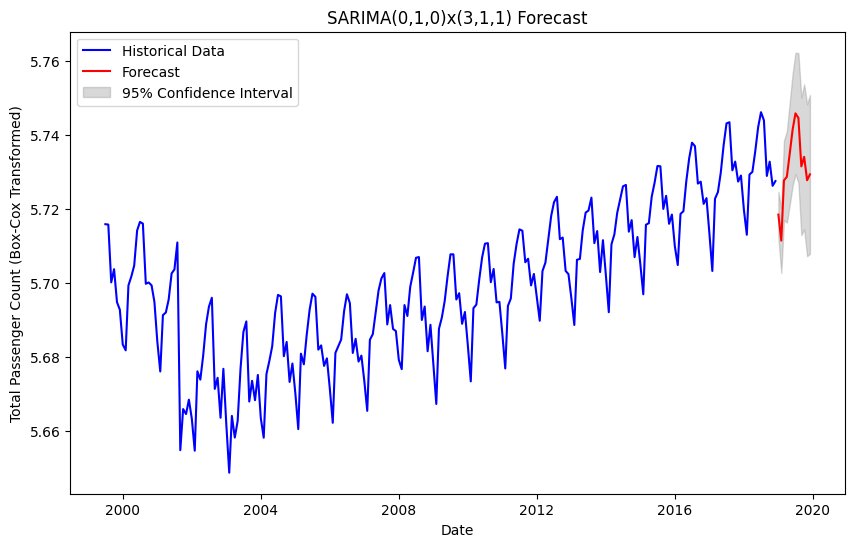

234    5.718372
235    5.711341
236    5.727617
237    5.728611
238    5.734826
239    5.741365
240    5.745748
241    5.744511
242    5.731407
243    5.733994
244    5.727671
245    5.729257
Name: predicted_mean, dtype: float64
Activity Period Start Date
1999-07-01    5.715787
1999-08-01    5.715680
1999-09-01    5.700058
1999-10-01    5.703612
1999-11-01    5.694691
                ...   
2018-08-01    5.743862
2018-09-01    5.728836
2018-10-01    5.732686
2018-11-01    5.726151
2018-12-01    5.727446
Name: Total Passenger Count (Box-Cox), Length: 234, dtype: float64


Date  Forecast  Lower Bound  Upper Bound
0  2019-01-01     5.718        5.712        5.725
1  2019-02-01     5.711        5.703        5.720
2  2019-03-01     5.728        5.717        5.738
3  2019-04-01     5.729        5.716        5.741
4  2019-05-01     5.735        5.721        5.749
5  2019-06-01     5.741        5.726        5.757
6  2019-07-01     5.746        5.729        5.762
7  2019-08-01     5.745        5.727        5.762
8  2019-09-01     5.731        5.713        5.750
9  2019-10-01     5.734        5.714        5.754
10 2019-11-01     5.728        5.707        5.748
11 2019-12-01     5.729        5.708        5.751

In [ ]:
# Forecast the next 12 periods (e.g., 12 months)
forecast_steps = 12
forecast_values_1 = sarima_1_results.get_forecast(steps=forecast_steps)

# Get the predicted mean and confidence intervals
forecast_mean_1 = forecast_values_1.predicted_mean
confidence_intervals_1 = forecast_values_1.conf_int()

# Ensure the index of df_train is a datetime
df_train = df_train.copy()
if not isinstance(df_train.index, pd.DatetimeIndex):
    if 'Activity Period Start Date' in df_train.columns:
        df_train['Activity Period Start Date'] = pd.to_datetime(df_train['Activity Period Start Date'])
        df_train.set_index('Activity Period Start Date', inplace=True)
    else:
        raise ValueError("No datetime index or 'Activity Period Start Date' column found.")

# Generate forecast index with month-start frequency
forecast_index = pd.date_range(
    start=df_train.index[-1] + pd.DateOffset(months=1),  # Start one month after the last date
    periods=forecast_steps,
    freq='MS'  # Month-start frequency
)

print(df_train.index[-1])
print(forecast_index)

# Proceed with the rest of the forecasting and plotting code
# Plot the forecasted values along with the historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(df_train.index, df_train[target_column], label="Historical Data", color='blue')

# Plot forecasted values
plt.plot(forecast_index, forecast_mean_1, label="Forecast", color='red')

# Plot the confidence intervals
plt.fill_between(
    forecast_index,
    confidence_intervals_1.iloc[:, 0],  # Lower bound
    confidence_intervals_1.iloc[:, 1],  # Upper bound
    color='gray', alpha=0.3, label="95% Confidence Interval"
)

plt.title("SARIMA(0,1,0)x(3,1,1) Forecast")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count (Box-Cox Transformed)")
plt.legend()
plt.show()

print(forecast_mean_1)
print(df_train[target_column])

# Format DataFrame for display with 3 decimal places
forecast_df_1 = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_mean_1.round(3),
    'Lower Bound': confidence_intervals_1.iloc[:, 0].round(3),
    'Upper Bound': confidence_intervals_1.iloc[:, 1].round(3)
})

# Reset index for clean display
forecast_df_1.reset_index(drop=True, inplace=True)

# Display the DataFrame in a Jupyter notebook
display(forecast_df_1)

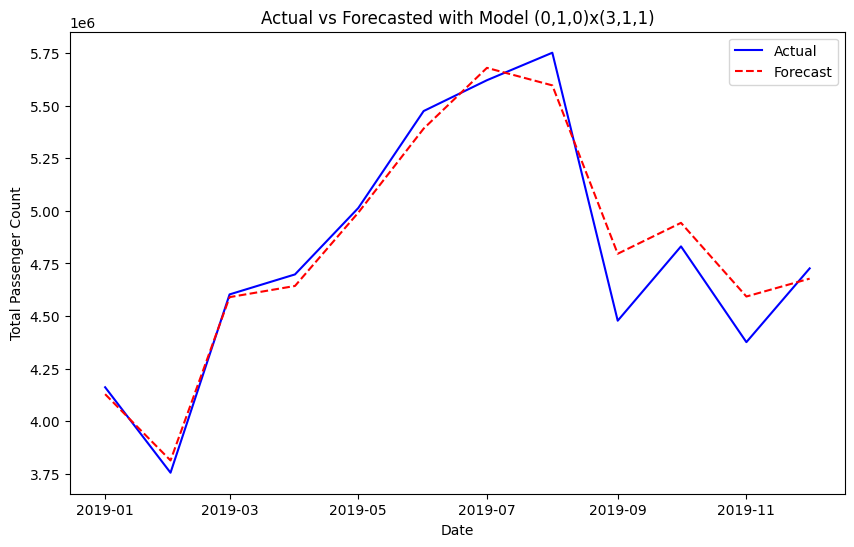

In [ ]:
# Step 1: Inverse transform the forecasted values
forecast_original_scale_1 = inv_boxcox(forecast_mean_1, lambda_value)

# Step 2: Prepare test dataset
# Ensure the test dataset has the original scale for comparison
actual_values = df_test["Total Passenger Count"]  # Replace with the original column name
if not isinstance(actual_values.index, pd.DatetimeIndex):
    actual_values.index = pd.to_datetime(df_test["Activity Period Start Date"])

# Align forecast index with actual values
forecast_index = forecast_index[:len(actual_values)]  # Ensure same length
forecast_original_scale_1 = forecast_original_scale_1[:len(actual_values)]

# Optional: Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values, label="Actual", color="blue")
plt.plot(forecast_index, forecast_original_scale_1, label="Forecast", color="red", linestyle="--")
plt.title("Actual vs Forecasted with Model (0,1,0)x(3,1,1)")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count")
plt.legend()
plt.show()

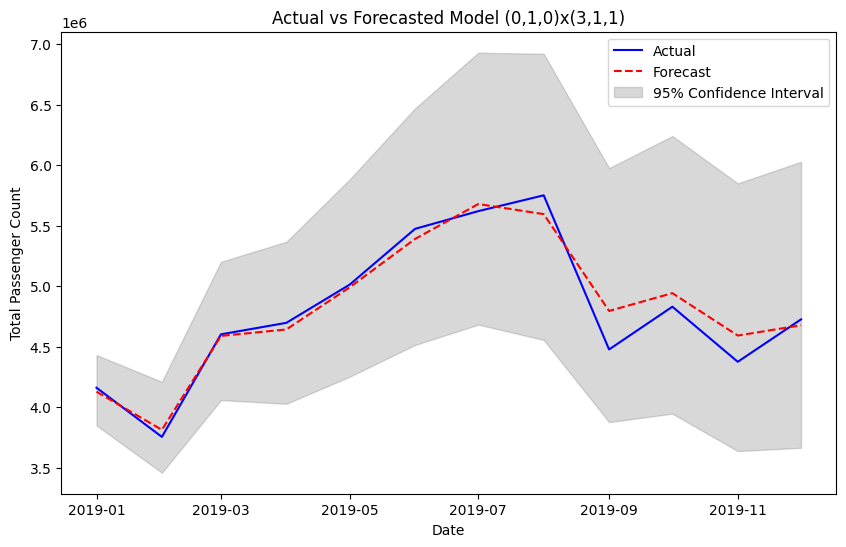

In [ ]:
# Step 1: Inverse transform the confidence intervals for Model 1
lower_bound_1 = inv_boxcox(confidence_intervals_1.iloc[:, 0], lambda_value)
upper_bound_1 = inv_boxcox(confidence_intervals_1.iloc[:, 1], lambda_value)

# Step 2: Align the forecast index with the actual values for Model 1
forecast_index_1 = forecast_index[:len(actual_values)]  # Ensure same length for plotting
lower_bound_1 = lower_bound_1[:len(actual_values)]
upper_bound_1 = upper_bound_1[:len(actual_values)]

# Step 3: Plot the actual vs forecasted values with confidence intervals for Model 1
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(actual_values.index, actual_values, label="Actual", color="blue")

# Plot forecasted values
plt.plot(actual_values.index, forecast_original_scale_1, label="Forecast", color="red", linestyle="--")

# Plot confidence intervals (upper and lower bounds)
plt.fill_between(forecast_index, lower_bound_1, upper_bound_1, color='gray', alpha=0.3, label="95% Confidence Interval")

# Plot title and labels
plt.title("Actual vs Forecasted Model (0,1,0)x(3,1,1)")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count")
plt.legend()

# Show plot
plt.show()

In [ ]:
forecast_original_scale_1.name = 'Total Passenger Count'  # Rename to match actual_values column
# Convert actual_values to float64 for compatibility
actual_values = actual_values.astype('float64')

# Now assign this new datetime index to forecast_original_scale
forecast_original_scale_1.index = forecast_index

In [ ]:
# Step 3: Calculate evaluation metrics for Model 1
mae_1 = mean_absolute_error(actual_values, forecast_original_scale_1)
rmse_1 = np.sqrt(mean_squared_error(actual_values, forecast_original_scale_1))
mape_1 = np.mean(np.abs((actual_values - forecast_original_scale_1) / (actual_values + 1e-6))) * 100
mean_value = actual_values.mean()
relative_error_mae_1 = mae_1 / mean_value * 100  # Percentage of MAE for Model 1
relative_error_rmse_1 = rmse_1 / mean_value * 100  # Percentage of RMSE for Model 1

# Step 3.1: Calculate Theil's U statistic for Model 2


# Calculate the difference between consecutive values (without worrying about the date index)
differences = np.abs(actual_values.values[1:] - actual_values.values[:-1])  # Calculate absolute differences

# Calculate the denominator (mean of absolute differences for naive forecast)
denominator = np.mean(differences)

# Calculate the numerator (RMSE)
numerator = np.sqrt(np.mean((forecast_original_scale_1 - actual_values) ** 2))

# Theil's U Statistic calculation
theil_u_1 = numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero

# Step 4: Print and interpret metrics for Model 1
print("Model 1 Evaluation Metrics:")
print(f"Mean Absolute Error (MAE_1): {mae_1}")
print(f"Root Mean Square Error (RMSE_1): {rmse_1}")
print(f"Relative Mean Absolute Error (MAE_1): {relative_error_mae_1}")
print(f"Relative Root Mean Square Error (RMSE_1): {relative_error_rmse_1}")
print(f"Mean Absolute Percentage Error (MAPE_1): {mape_1:.9f}%")
print(f"Theil's U Statistic (Theil_U_2): {theil_u_1:.9f}")

Model 1 Evaluation Metrics:
Mean Absolute Error (MAE_1): 97772.71905865539
Root Mean Square Error (RMSE_1): 130875.80427754334
Relative Mean Absolute Error (MAE_1): 2.0408992473160277
Relative Root Mean Square Error (RMSE_1): 2.731890173594107
Mean Absolute Percentage Error (MAPE_1): 2.074198076%
Theil's U Statistic (Theil_U_2): 0.297953994


## SARIMA(0,1,1)x(3,1,1)

In [ ]:
# Forecast the next 12 periods (e.g., 12 months)
forecast_steps = 12

forecast_values_2 = sarima_2_results.get_forecast(steps=forecast_steps)

# Get the predicted mean and confidence intervals
forecast_mean_2 = forecast_values_2.predicted_mean
confidence_intervals_2 = forecast_values_2.conf_int()

In [ ]:
# Ensure the index of df_train is a datetime
df_train = df_train.copy()
if not isinstance(df_train.index, pd.DatetimeIndex):
    if 'Activity Period Start Date' in df_train.columns:
        df_train['Activity Period Start Date'] = pd.to_datetime(df_train['Activity Period Start Date'])
        df_train.set_index('Activity Period Start Date', inplace=True)
    else:
        raise ValueError("No datetime index or 'Activity Period Start Date' column found.")

In [ ]:
# Generate forecast index with month-start frequency
forecast_index = pd.date_range(
    start=df_train.index[-1] + pd.DateOffset(months=1),  # Start one month after the last date
    periods=forecast_steps,
    freq='MS'  # Month-start frequency
)

print(df_train.index[-1])
print(forecast_index)

2018-12-01 00:00:00
DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')


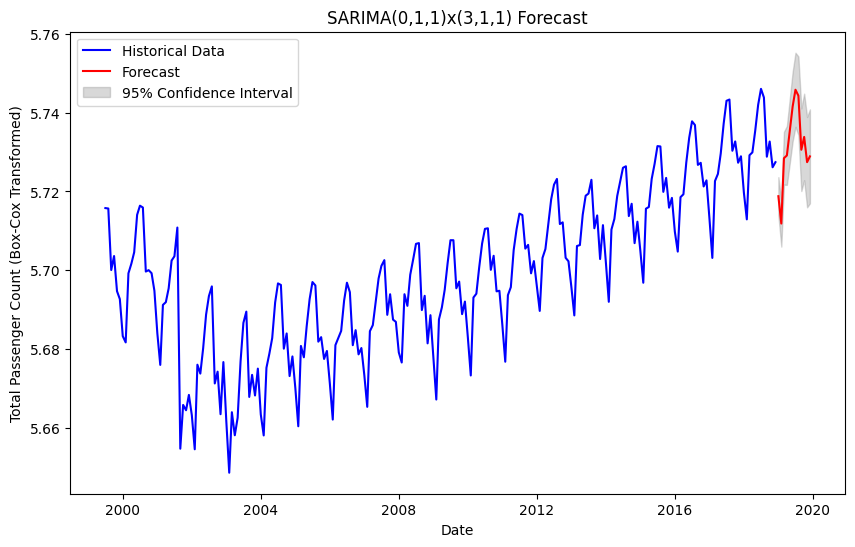

In [ ]:
# Proceed with the rest of the forecasting and plotting code
# Plot the forecasted values along with the historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(df_train.index, df_train[target_column], label="Historical Data", color='blue')

# Plot forecasted values
plt.plot(forecast_index, forecast_mean_2, label="Forecast", color='red')

# Plot the confidence intervals
plt.fill_between(
    forecast_index,
    confidence_intervals_2.iloc[:, 0],  # Lower bound
    confidence_intervals_2.iloc[:, 1],  # Upper bound
    color='gray', alpha=0.3, label="95% Confidence Interval"
)

plt.title("SARIMA(0,1,1)x(3,1,1) Forecast")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count (Box-Cox Transformed)")
plt.legend()
plt.show()

In [ ]:
# Format DataFrame for display with 3 decimal places
forecast_df_2 = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_mean_2.round(3),
    'Lower Bound': confidence_intervals_2.iloc[:, 0].round(3),
    'Upper Bound': confidence_intervals_2.iloc[:, 1].round(3)
})

# Reset index for clean display
forecast_df_2.reset_index(drop=True, inplace=True)

# Display the DataFrame in a Jupyter notebook
display(forecast_df_2)


df_train[target_column].to_csv('forecast_historic_SARIMA(0,1,1)x(3,1,1).csv', index = False)
forecast_df_2.to_csv('forecast_future_SARIMA(0,1,1)x(3,1,1).csv', index = False)

Date  Forecast  Lower Bound  Upper Bound
0  2019-01-01     5.719        5.714        5.724
1  2019-02-01     5.712        5.706        5.718
2  2019-03-01     5.728        5.722        5.735
3  2019-04-01     5.729        5.722        5.737
4  2019-05-01     5.735        5.727        5.743
5  2019-06-01     5.742        5.733        5.750
6  2019-07-01     5.746        5.736        5.755
7  2019-08-01     5.744        5.734        5.754
8  2019-09-01     5.731        5.720        5.741
9  2019-10-01     5.734        5.723        5.745
10 2019-11-01     5.727        5.716        5.739
11 2019-12-01     5.729        5.717        5.741

234    4.149386e+06
235    3.836542e+06
236    4.634763e+06
237    4.671986e+06
238    5.014583e+06
239    5.402849e+06
240    5.684809e+06
241    5.583075e+06
242    4.751128e+06
243    4.934420e+06
244    4.581001e+06
245    4.659303e+06
Name: predicted_mean, dtype: float64
Activity Period Start Date
2019-01-01    4161927
2019-02-01    3755973
2019-03-01    4602873
2019-04-01    4697790
2019-05-01    5013085
2019-06-01    5473791
2019-07-01    5620160
2019-08-01    5750758
2019-09-01    4478000
2019-10-01    4831007
2019-11-01    4376146
2019-12-01    4726513
Name: Total Passenger Count, dtype: int64
234    4.149386e+06
235    3.836542e+06
236    4.634763e+06
237    4.671986e+06
238    5.014583e+06
239    5.402849e+06
240    5.684809e+06
241    5.583075e+06
242    4.751128e+06
243    4.934420e+06
244    4.581001e+06
245    4.659303e+06
Name: predicted_mean, dtype: float64


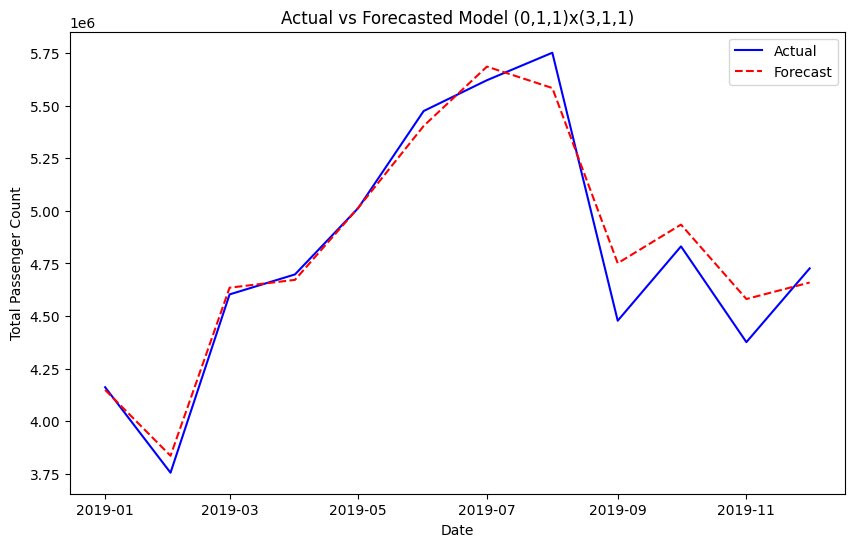

In [ ]:
# Step 1: Inverse transform the forecasted values
forecast_original_scale_2 = inv_boxcox(forecast_mean_2, lambda_value)
print(forecast_original_scale_2)

# Step 2: Prepare test dataset
# Ensure the test dataset has the original scale for comparison
actual_values = df_test["Total Passenger Count"]  # Replace with the original column name
print(actual_values)
if not isinstance(actual_values.index, pd.DatetimeIndex):
    actual_values.index = pd.to_datetime(df_test["Activity Period Start Date"])

# Align forecast index with actual values
forecast_index = forecast_index[:len(actual_values)]  # Ensure same length
forecast_original_scale_2 = forecast_original_scale_2[:len(actual_values)]
print(forecast_original_scale_2)

# Optional: Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values, label="Actual", color="blue")
plt.plot(forecast_index, forecast_original_scale_2, label="Forecast", color="red", linestyle="--")
plt.title("Actual vs Forecasted Model (0,1,1)x(3,1,1)")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count")
plt.legend()
plt.show()

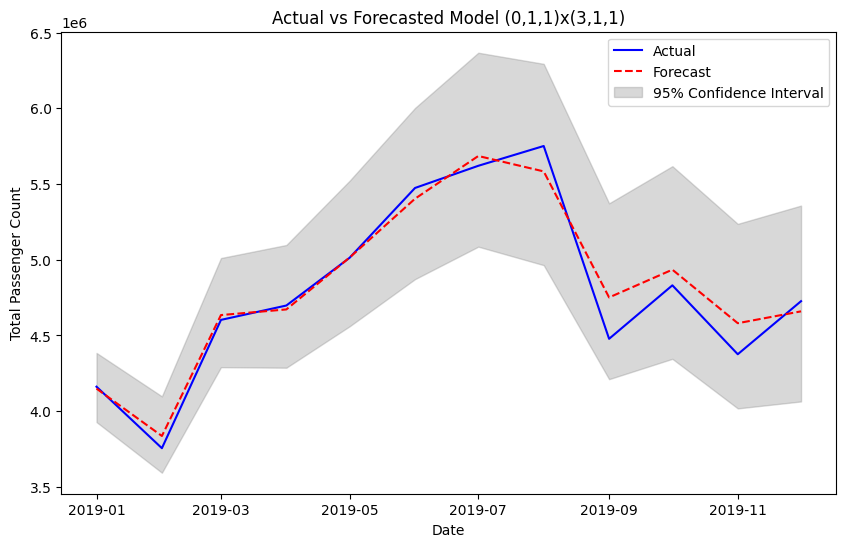

In [ ]:
# Step 1: Inverse transform the confidence intervals
lower_bound_2 = inv_boxcox(confidence_intervals_2.iloc[:, 0], lambda_value)
upper_bound_2 = inv_boxcox(confidence_intervals_2.iloc[:, 1], lambda_value)

# Step 2: Align the forecast index with the actual values
forecast_index = forecast_index[:len(actual_values)]  # Ensure same length for plotting
lower_bound_2 = lower_bound_2[:len(actual_values)]
upper_bound_2 = upper_bound_2[:len(actual_values)]

# Step 3: Plot the actual vs forecasted values with confidence intervals
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(actual_values.index, actual_values, label="Actual", color="blue")

# Plot forecasted values
plt.plot(forecast_index, forecast_original_scale_2, label="Forecast", color="red", linestyle="--")

# Plot confidence intervals (upper and lower bounds)
plt.fill_between(forecast_index, lower_bound_2, upper_bound_2, color='gray', alpha=0.3, label="95% Confidence Interval")

# Plot title and labels
plt.title("Actual vs Forecasted Model (0,1,1)x(3,1,1)")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count")
plt.legend()

# Show plot
plt.show()

In [ ]:
# Now assign this new datetime index to forecast_original_scale
forecast_original_scale_2.index = forecast_index
print(forecast_original_scale_2)

# Perform the subtraction (ensure actual_values also has the same length and is indexed by date)
difference = actual_values - forecast_original_scale_2
print(difference)

2019-01-01    4.149386e+06
2019-02-01    3.836542e+06
2019-03-01    4.634763e+06
2019-04-01    4.671986e+06
2019-05-01    5.014583e+06
2019-06-01    5.402849e+06
2019-07-01    5.684809e+06
2019-08-01    5.583075e+06
2019-09-01    4.751128e+06
2019-10-01    4.934420e+06
2019-11-01    4.581001e+06
2019-12-01    4.659303e+06
Freq: MS, Name: predicted_mean, dtype: float64
Activity Period Start Date
2019-01-01     12541.405409
2019-02-01    -80568.953686
2019-03-01    -31889.549203
2019-04-01     25804.199656
2019-05-01     -1498.489844
2019-06-01     70942.032567
2019-07-01    -64649.491908
2019-08-01    167682.954527
2019-09-01   -273128.096438
2019-10-01   -103412.576840
2019-11-01   -204855.062320
2019-12-01     67210.023020
dtype: float64


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 3: Calculate evaluation metrics for Model 2
mae_2 = mean_absolute_error(actual_values, forecast_original_scale_2)
rmse_2 = np.sqrt(mean_squared_error(actual_values, forecast_original_scale_2))
mape_2 = np.mean(np.abs((actual_values - forecast_original_scale_2) / (actual_values + 1e-6))) * 100
mean_value = actual_values.mean()
relative_error_mae_2 = mae_2 / mean_value * 100  # Percentage of MAE for Model 2
relative_error_rmse_2 = rmse_2 / mean_value * 100  # Percentage of RMSE for Model 2

# Step 3.1: Calculate Theil's U statistic for Model 2


# Calculate the difference between consecutive values (without worrying about the date index)
differences = np.abs(actual_values.values[1:] - actual_values.values[:-1])  # Calculate absolute differences

# Calculate the denominator (mean of absolute differences for naive forecast)
denominator = np.mean(differences)

# Calculate the numerator (RMSE)
numerator = np.sqrt(np.mean((forecast_original_scale_2 - actual_values) ** 2))

# Theil's U Statistic calculation
theil_u_2 = numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero

# Step 4: Print and interpret metrics for Model 2
print("Model 2 Evaluation Metrics:")
print(f"Mean Absolute Error (MAE_2): {mae_2}")
print(f"Root Mean Square Error (RMSE_2): {rmse_2}")
print(f"Relative Mean Absolute Error (MAE_2): {relative_error_mae_2}")
print(f"Relative Root Mean Square Error (RMSE_2): {relative_error_rmse_2}")
print(f"Mean Absolute Percentage Error (MAPE_2): {mape_2:.9f}%")
print(f"Theil's U Statistic (Theil_U_2): {theil_u_2:.9f}")

Model 2 Evaluation Metrics:
Mean Absolute Error (MAE_2): 92015.23628482521
Root Mean Square Error (RMSE_2): 121600.26472716381
Relative Mean Absolute Error (MAE_2): 1.9207180518590847
Relative Root Mean Square Error (RMSE_2): 2.5382733664818597
Mean Absolute Percentage Error (MAPE_2): 1.951974362%
Theil's U Statistic (Theil_U_2): 0.276837149


## SARIMA (0,1,1)x(2,0,2)

In [ ]:
# Forecast the next 12 periods (e.g., 12 months)
forecast_steps = 12
forecast_values_5 = sarima_5_results.get_forecast(steps=forecast_steps)

# Get the predicted mean and confidence intervals
forecast_mean_5 = forecast_values_5.predicted_mean
confidence_intervals_5 = forecast_values_5.conf_int()

# Ensure the index of df_train is a datetime
df_train = df_train.copy()
if not isinstance(df_train.index, pd.DatetimeIndex):
    if 'Activity Period Start Date' in df_train.columns:
        df_train['Activity Period Start Date'] = pd.to_datetime(df_train['Activity Period Start Date'])
        df_train.set_index('Activity Period Start Date', inplace=True)
    else:
        raise ValueError("No datetime index or 'Activity Period Start Date' column found.")

# Generate forecast index with month-start frequency
forecast_index = pd.date_range(
    start=df_train.index[-1] + pd.DateOffset(months=1),  # Start one month after the last date
    periods=forecast_steps,
    freq='MS'  # Month-start frequency
)

print(df_train.index[-1])
print(forecast_index)

2018-12-01 00:00:00
DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', freq='MS')


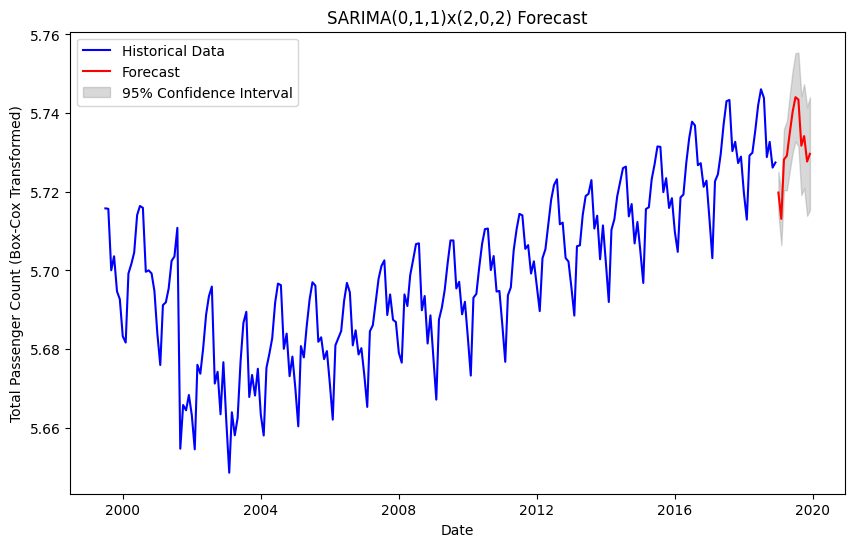

234    5.719805
235    5.713123
236    5.728208
237    5.729171
238    5.734859
239    5.740344
240    5.744049
241    5.743444
242    5.731716
243    5.734162
244    5.727682
245    5.729653
Name: predicted_mean, dtype: float64
Activity Period Start Date
1999-07-01    5.715787
1999-08-01    5.715680
1999-09-01    5.700058
1999-10-01    5.703612
1999-11-01    5.694691
                ...   
2018-08-01    5.743862
2018-09-01    5.728836
2018-10-01    5.732686
2018-11-01    5.726151
2018-12-01    5.727446
Name: Total Passenger Count (Box-Cox), Length: 234, dtype: float64


Date  Forecast  Lower Bound  Upper Bound
0  2019-01-01     5.720        5.714        5.725
1  2019-02-01     5.713        5.706        5.720
2  2019-03-01     5.728        5.720        5.736
3  2019-04-01     5.729        5.720        5.738
4  2019-05-01     5.735        5.725        5.745
5  2019-06-01     5.740        5.730        5.751
6  2019-07-01     5.744        5.733        5.755
7  2019-08-01     5.743        5.732        5.755
8  2019-09-01     5.732        5.719        5.744
9  2019-10-01     5.734        5.721        5.747
10 2019-11-01     5.728        5.714        5.741
11 2019-12-01     5.730        5.715        5.744

In [ ]:
# Proceed with the rest of the forecasting and plotting code
# Plot the forecasted values along with the historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(df_train.index, df_train[target_column], label="Historical Data", color='blue')

# Plot forecasted values
plt.plot(forecast_index, forecast_mean_5, label="Forecast", color='red')

# Plot the confidence intervals
plt.fill_between(
    forecast_index,
    confidence_intervals_5.iloc[:, 0],  # Lower bound
    confidence_intervals_5.iloc[:, 1],  # Upper bound
    color='gray', alpha=0.3, label="95% Confidence Interval"
)

plt.title("SARIMA(0,1,1)x(2,0,2) Forecast")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count (Box-Cox Transformed)")
plt.legend()
plt.show()

print(forecast_mean_5)
print(df_train[target_column])

# Format DataFrame for display with 3 decimal places
forecast_df_5 = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast_mean_5.round(3),
    'Lower Bound': confidence_intervals_5.iloc[:, 0].round(3),
    'Upper Bound': confidence_intervals_5.iloc[:, 1].round(3)
})

# Reset index for clean display
forecast_df_5.reset_index(drop=True, inplace=True)

# Display the DataFrame in a Jupyter notebook
display(forecast_df_5)

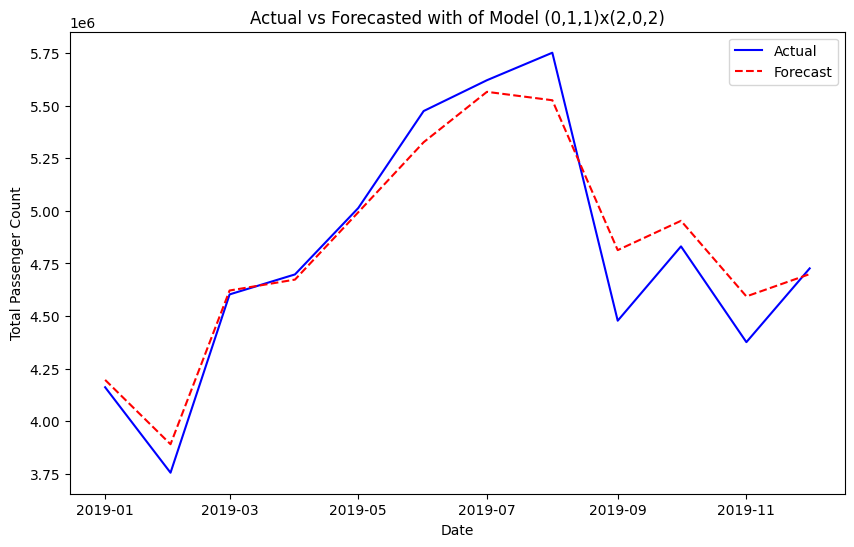

In [ ]:
# Step 1: Inverse transform the forecasted values
forecast_original_scale_5 = inv_boxcox(forecast_mean_5, lambda_value)

# Step 2: Prepare test dataset
# Ensure the test dataset has the original scale for comparison
actual_values = df_test["Total Passenger Count"]  # Replace with the original column name
if not isinstance(actual_values.index, pd.DatetimeIndex):
    actual_values.index = pd.to_datetime(df_test["Activity Period Start Date"])

# Align forecast index with actual values
forecast_index = forecast_index[:len(actual_values)]  # Ensure same length
forecast_original_scale_5 = forecast_original_scale_5[:len(actual_values)]

# Optional: Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values, label="Actual", color="blue")
plt.plot(forecast_index, forecast_original_scale_5, label="Forecast", color="red", linestyle="--")
plt.title("Actual vs Forecasted with of Model (0,1,1)x(2,0,2)")
plt.xlabel("Date")
plt.ylabel("Total Passenger Count")
plt.legend()
plt.show()

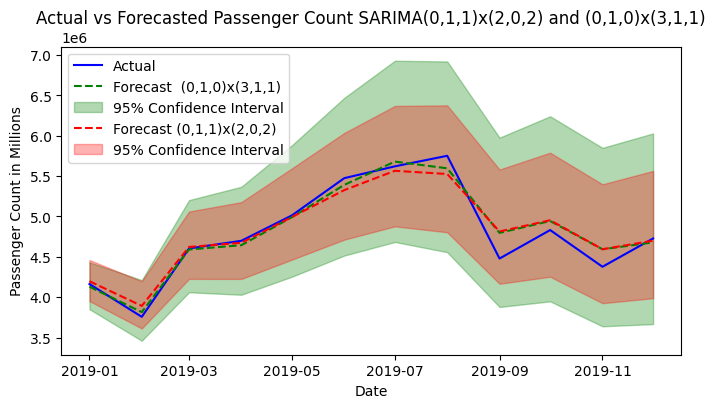

In [ ]:
# Step 1: Inverse transform the confidence intervals for Model 5
lower_bound_5 = inv_boxcox(confidence_intervals_5.iloc[:, 0], lambda_value)
upper_bound_5 = inv_boxcox(confidence_intervals_5.iloc[:, 1], lambda_value)

# Step 2: Align the forecast index with the actual values for Model 5
forecast_index_5 = forecast_index[:len(actual_values)]  # Ensure same length for plotting
lower_bound_5 = lower_bound_5[:len(actual_values)]
upper_bound_5 = upper_bound_5[:len(actual_values)]

# Step 1: Inverse transform the confidence intervals for Model 1
lower_bound_1 = inv_boxcox(confidence_intervals_1.iloc[:, 0], lambda_value)
upper_bound_1 = inv_boxcox(confidence_intervals_1.iloc[:, 1], lambda_value)

# Step 2: Align the forecast index with the actual values for Model 1
forecast_index_1 = forecast_index[:len(actual_values)]  # Ensure same length for plotting
lower_bound_1 = lower_bound_1[:len(actual_values)]
upper_bound_1 = upper_bound_1[:len(actual_values)]

# Step 3: Plot the actual vs forecasted values with confidence intervals for Model 5
plt.figure(figsize=(8, 4))

# Plot actual values
plt.plot(actual_values.index, actual_values, label="Actual", color="blue")

# Plot forecasted values
plt.plot(actual_values.index, forecast_original_scale_1, label="Forecast  (0,1,0)x(3,1,1)", color="green", linestyle="--")

# Plot confidence intervals (upper and lower bounds)
plt.fill_between(forecast_index, lower_bound_1, upper_bound_1, color='green', alpha=0.3, label="95% Confidence Interval")

# Plot forecasted values
plt.plot(actual_values.index, forecast_original_scale_5, label="Forecast (0,1,1)x(2,0,2)", color="red", linestyle="--")

# Plot confidence intervals (upper and lower bounds)
plt.fill_between(forecast_index, lower_bound_5, upper_bound_5, color='red', alpha=0.3, label="95% Confidence Interval")

# Plot title and labels
plt.title("Actual vs Forecasted Passenger Count SARIMA(0,1,1)x(2,0,2) and (0,1,0)x(3,1,1)")
plt.xlabel("Date")
plt.ylabel("Passenger Count in Millions")
plt.legend()

# Show plot
plt.show()

In [ ]:
forecast_original_scale_5.name = 'Total Passenger Count'  # Rename to match actual_values column
# Convert actual_values to float64 for compatibility
actual_values = actual_values.astype('float64')

# Now assign this new datetime index to forecast_original_scale
forecast_original_scale_5.index = forecast_index

In [ ]:
# Step 3: Calculate evaluation metrics for Model 5
mae_5 = mean_absolute_error(actual_values, forecast_original_scale_5)
rmse_5 = np.sqrt(mean_squared_error(actual_values, forecast_original_scale_5))
mape_5 = np.mean(np.abs((actual_values - forecast_original_scale_5) / (actual_values + 1e-6))) * 100
relative_error_mae_5 = mae_5 / mean_value * 100  # Percentage of MAE for Model 5
relative_error_rmse_5 = rmse_5 / mean_value * 100  # Percentage of RMSE for Model 5


# Calculate the difference between consecutive values (without worrying about the date index)
differences = np.abs(actual_values.values[1:] - actual_values.values[:-1])  # Calculate absolute differences

# Calculate the denominator (mean of absolute differences for naive forecast)
denominator = np.mean(differences)

# Calculate the numerator (RMSE)
numerator = np.sqrt(np.mean((forecast_original_scale_5 - actual_values) ** 2))

# Theil's U Statistic calculation
theil_u_5 = numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero


# Step 4: Print and interpret metrics for Model 5
print("Model 5 Evaluation Metrics:")
print(f"Mean Absolute Error (MAE_5): {mae_5}")
print(f"Root Mean Square Error (RMSE_5): {rmse_5}")
print(f"Relative Mean Absolute Error (MAE_5): {relative_error_mae_5}")
print(f"Relative Root Mean Square Error (RMSE_5): {relative_error_rmse_5}")
print(f"Mean Absolute Percentage Error (MAPE_5): {mape_5:.9f}%")
print(f"Theil's U Statistic (Theil_U_2): {theil_u_5:.9f}")

Model 5 Evaluation Metrics:
Mean Absolute Error (MAE_5): 113629.69060024184
Root Mean Square Error (RMSE_5): 150522.14187845364
Relative Mean Absolute Error (MAE_5): 2.371896294299253
Relative Root Mean Square Error (RMSE_5): 3.141986118641519
Mean Absolute Percentage Error (MAPE_5): 2.410072166%
Theil's U Statistic (Theil_U_2): 0.342681167


## Other forecasts

### Rolling window forecast

In [ ]:
def rolling_forecast_sarima(data, train_len, forecast_len, order, seasonal_order, target_column):
    """
    Performs rolling forecast with SARIMA model, including Box-Cox transformation.

    Args:
        data: Pandas DataFrame containing the time series data.
        train_len: Length of the initial training window.
        forecast_len: Number of steps to forecast at each iteration.
        order: Tuple (p, d, q) for the non-seasonal part of the SARIMA model.
        seasonal_order: Tuple (P, D, Q, m) for the seasonal part of the SARIMA model.
        target_column: Name of the target column in the DataFrame.

    Returns:
        Pandas DataFrame with the actual values, forecasted values, and errors.
    """

    # Initialize lists to store results
    all_forecasts = []
    all_actual_values = []

    # Rolling forecast loop
    for i in range(train_len, len(data) - forecast_len + 1):
        # Split data into train and test sets
        train_data = data[target_column].iloc[:i]  # Original scale
        test_data = data[target_column].iloc[i: i + forecast_len]  # Original scale

        # Create and fit the SARIMA model on transformed data
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)

        # Generate forecasts on transformed scale
        forecast = model_fit.get_forecast(steps=forecast_len)
        forecast_values_transformed = forecast.predicted_mean

        # Store results
        all_forecasts.extend(forecast_values_transformed)  # Extend with predicted values
        all_actual_values.extend(test_data.values)  # Extend with actual values

    # Create a DataFrame to store results
    results_df = pd.DataFrame({"Actual": all_actual_values, "Forecast": all_forecasts})
    results_df["Error"] = results_df["Actual"] - results_df["Forecast"]

    return results_df

In [ ]:
# Set parameters
forecast_len = 36  # Forecast horizon
train_len = len(df_train) - forecast_len  # Length of initial training window
order = (0, 1, 0)  # Non-seasonal order (p, d, q)
seasonal_order = (3, 1, 1, 12)  # Seasonal order (P, D, Q, m)
target_column = "Total Passenger Count (Box-Cox)"  # Name of the target column

# Call the rolling forecast function
results_df = rolling_forecast_sarima(
    df_train, train_len, forecast_len, order, seasonal_order, target_column)

In [ ]:
# Step 3: Calculate evaluation metrics for Model Rolling

actual_values = inv_boxcox(results_df['Actual'], lambda_value)
forecast_rolling = inv_boxcox(results_df['Forecast'], lambda_value)

mae = mean_absolute_error(actual_values, forecast_rolling)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_rolling))
mape = np.mean(np.abs((actual_values - forecast_rolling) / (actual_values + 1e-6))) * 100
relative_error_mae = mae / mean_value * 100  # Percentage of MAE for Model Rolling
relative_error_rmse = rmse / mean_value * 100  # Percentage of RMSE for Model Rolling


# Calculate the difference between consecutive values (without worrying about the date index)
differences = np.abs(actual_values.values[1:] - actual_values.values[:-1])  # Calculate absolute differences

# Calculate the denominator (mean of absolute differences for naive forecast)
denominator = np.mean(differences)

# Calculate the numerator (RMSE)
numerator = np.sqrt(np.mean((forecast_rolling - actual_values) ** 2))

# Theil's U Statistic calculation
theil_u = numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero


# Step 4: Print and interpret metrics for Model 5
print("Model Rolling Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Relative Mean Absolute Error (MAE): {relative_error_mae:.4f}%")
print(f"Relative Root Mean Square Error (RMSE): {relative_error_rmse}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Theil's U Statistic (Theil_U): {theil_u:.4f}")

Model Rolling Evaluation Metrics:
Mean Absolute Error (MAE): 95664.63358316047
Root Mean Square Error (RMSE): 117610.57054673649
Relative Mean Absolute Error (MAE): 1.9969%
Relative Root Mean Square Error (RMSE): 2.454992836613703%
Mean Absolute Percentage Error (MAPE): 2.0753%
Theil's U Statistic (Theil_U): 0.3631


### Recursive window forecast

In [ ]:
from copy import deepcopy

forecast_horizon = 12  # Number of periods to forecast
forecasts = []
df_train_copy = deepcopy(df_train)  # Create a copy of df_train

for i in range(forecast_horizon):
    # Fit the model on the available data (including previous forecasts)
    model = SARIMAX(
        df_train_copy[target_column],  # Replace target_column with your target variable
        order=(0, 1, 1),
        seasonal_order=(3, 1, 1, 12),  # Adjust seasonal order if needed
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # Make a one-step-ahead forecast
    forecast = model_fit.get_forecast(steps=1).predicted_mean[0]

    # Append the forecast to the list
    forecasts.append(forecast)

    # Update the training data with the forecast for the next iteration
    df_train_copy = pd.concat([df_train_copy, pd.DataFrame({target_column: [forecast]}, index=[df_train_copy.index[-1] + pd.DateOffset(months=1)])])

forecasts_recursive = inv_boxcox(forecasts, lambda_value)

In [ ]:
# Step 3: Calculate evaluation metrics for Model Rolling

actual_values = df_test['Total Passenger Count']

mae = mean_absolute_error(actual_values, forecasts_recursive)
rmse = np.sqrt(mean_squared_error(actual_values, forecasts_recursive))
mape = np.mean(np.abs((actual_values - forecasts_recursive) / (actual_values + 1e-6))) * 100
relative_error_mae = mae / mean_value * 100  # Percentage of MAE for Model Rolling
relative_error_rmse = rmse / mean_value * 100  # Percentage of RMSE for Model Rolling


# Calculate the difference between consecutive values (without worrying about the date index)
differences = np.abs(actual_values.values[1:] - actual_values.values[:-1])  # Calculate absolute differences

# Calculate the denominator (mean of absolute differences for naive forecast)
denominator = np.mean(differences)

# Calculate the numerator (RMSE)
numerator = np.sqrt(np.mean((forecasts_recursive - actual_values) ** 2))

# Theil's U Statistic calculation
theil_u = numerator / (denominator + 1e-6)  # Add small epsilon to avoid division by zero


# Step 4: Print and interpret metrics for Model 5
print("Model Rolling Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Relative Mean Absolute Error (MAE): {relative_error_mae:.4f}%")
print(f"Relative Root Mean Square Error (RMSE): {relative_error_rmse}%")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print(f"Theil's U Statistic (Theil_U): {theil_u:.4f}")

Model Rolling Evaluation Metrics:
Mean Absolute Error (MAE): 92005.9940914384
Root Mean Square Error (RMSE): 121588.01370081822
Relative Mean Absolute Error (MAE): 1.9205%
Relative Root Mean Square Error (RMSE): 2.5380176396217675%
Mean Absolute Percentage Error (MAPE): 1.9516%
Theil's U Statistic (Theil_U): 0.2768


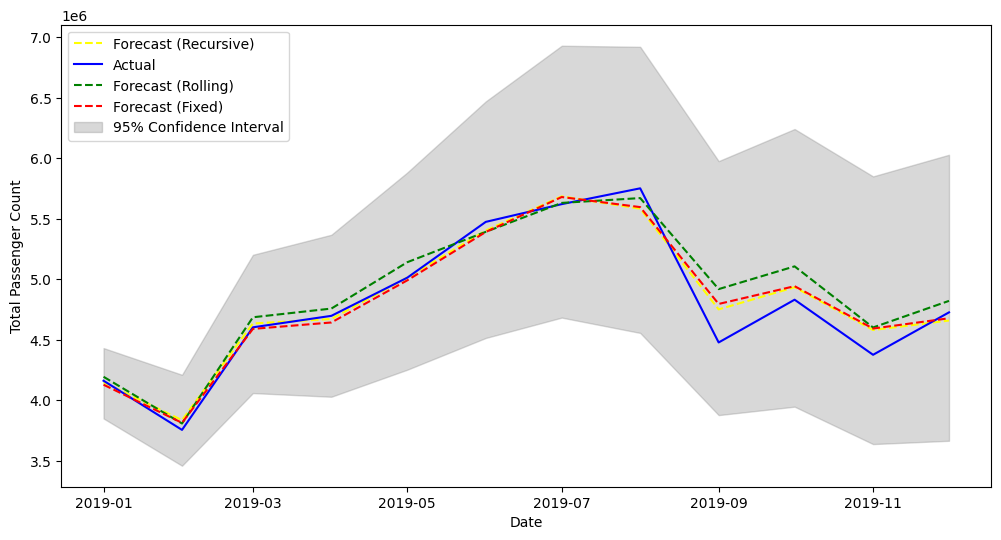

In [ ]:
# Create a date range for the forecast horizon
forecast_dates = pd.date_range(start=df_test['Activity Period Start Date'].iloc[0], periods=len(forecasts_recursive), freq='MS')

# Plot the forecasted and actual values
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecasts_recursive, label="Forecast (Recursive) ", color="yellow", linestyle = "--")
plt.plot(df_test['Activity Period Start Date'], df_test['Total Passenger Count'], label="Actual", color="blue")
plt.plot(forecast_dates, forecast_rolling[24:], label = "Forecast (Rolling)", color="green", linestyle = '--')
plt.plot(forecast_index, forecast_original_scale_1, label="Forecast (Fixed)", color="red", linestyle="--")

plt.fill_between(forecast_index, lower_bound_1, upper_bound_1, color='gray', alpha=0.3, label="95% Confidence Interval")

plt.xlabel("Date")
plt.ylabel("Total Passenger Count")
plt.legend()
plt.show()